In [1]:
'''
CMRMTSPL = Real Manufacturing and Trade Industries Sales
INDPRO = Industrial Production
W875RX1 = Real personal income excluding current transfer receipts
PAYEMS = Useful employment of data
Y033RX1Q020SBEA = Real Gross Private Domestic Investment: Fixed Investment: Nonresidential: Equipment
PCDGCC96 = spending on durable goods
DGDSRC1Q027SBEA = spending on goods
LB0000031Q020SBEA = real final sales to private domestic purchasers
A261RX1Q020SBEA = Real GDI
GDPC1 = Real Gross Domestic Product
PB0000091Q225SBEA = real gdp and gdi average
IA001260M = pce services excluding energy and housing
CUUR0000SASL2RS = CPI Services less Rent of Shelter
'''

'\nCMRMTSPL = Real Manufacturing and Trade Industries Sales\nINDPRO = Industrial Production\nW875RX1 = Real personal income excluding current transfer receipts\nPAYEMS = Useful employment of data\n'

In [100]:
import pandas as pd
import pandas_datareader.data as web
import seaborn
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import numpy as np
import datetime as dt
import sqlite3
import time
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from financetoolkit import Toolkit
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
import plotly.express as px
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import pandas_datareader.data as web

sns.set_theme()
import warnings
warnings.filterwarnings("ignore")

class Macro:
    
    """
    This class is mainly for my paper trading in spot markets. Derivatives will have a separate script. 
    """
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*50)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.symbols_list = "USREC",'CFNAI','CFNAIMA3','CUUR0000SASL2RS','IA001260M','PB0000091Q225SBEA','LB0000031Q020SBEA','PCDGCC96','DGDSRC1Q027SBEA','CPIAUCSL','BAMLC0A4CBBBEY','BAMLC0A1CAAAEY','USALOLITONOSTSAM','DRTSCILM','PCEPILFE','A261RX1Q020SBEA','DRTSCIS','IPMAN','INDPRO','M1V','M2V', 'WM2NS','UMCSENT','FEDFUNDS','PCETRIM12M159SFRBDAL','DGS10','DGS2','EFFR','DGS30','AAA','DBAA','BAMLH0A3HYC','BAMLH0A0HYM2','DRCCLOBS','TCU','ICSA','AWHMAN','NEWORDER','AMTMNO','PERMIT','WEI', 'WSHOTSL', 'WSHOMCB', 'WSHOFADSL', 'WLCFLL', 'WORAL',"WALCL", "WCURCIR", 'WDTGAL', 'WLRRAL','GCEC1','PCEC96','GDPC1','FRBATLWGTUMHWG83O','PCE','UNRATE','TDSP','PALLFNFINDEXQ','TEMPHELPS','JTSHIR','PSAVERT','FYFSGDA188S','CPILFESL','PI','LNS12300060','GDPNOW','JTSJOL','CDSP','DSPI','PMSAVE','T10Y3M','PAYEMS','W875RX1','CMRMTSPL','LNS11324230','T5YIFR','DPCCRV1Q225SBEA','ECIALLCIV','FRBKCLMCILA','CES0500000003'

    def macro(self):
        symbols = []
        for ticker in self.symbols_list: 
            try:
                r = web.DataReader(ticker,'fred', self.fred_start, self.fred_end)
                r['ticker'] = ticker
                symbols.append(r)
            except:
                msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
        try:
            connection = sqlite3.connect('tradable_universe')
            for i in symbols:
                i.columns = 'close','ticker'
            final = pd.concat(symbols)
            final_df = final.reset_index()
            final_df.to_sql("macro_signals",connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
        except:
            print("There was an error in uploading the macro table into the sql database")
        return symbols, final_df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'close')
        return df[start:end]
    
class Trading:
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*35)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.ticker_list = ["SPY",'RSP',"XLV","VNQ","XLP","XLU","MUB","SPLV","DEF","XLRE","IEF",
                            "GDXJ","MBB", "UUP","IIGD","PINK","IWM","XLP","HG=F","GC=F",'XLY','^DJT','^SP500-55',
                           '^SP500-30','^SP500-25','XLK','^RUT','TLT','GLD','QQQ','GDX','GDXJ','XOP','KRE',
                           'XBI','XLF','XLE','XRT','XLI','XHB','XLP','JNK','DIA','XME','SRLN','XLC','XLB','BIL',
                           'MDY','KBE','SJNK','CWB','SDY','FEZ','XAR','GNR','KIE','XES','XSW','XSD','GXC','SPEM',
                           'SPDW','XTN','SPMB','SLYV','EFIV','EFAX','MDYV','AGG','LQD','^VIX','^VVIX'] 
    
    def yahoo_universe(self):
        web3 = []
        failed = []
        for security in self.ticker_list:
            try:                                                    
                interval = '1d' 
                query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{security}?period1={self.period1}&period2={self.period2}&interval={self.interval}&events=history&includeAdjustedClose=true'
                df = pd.read_csv(query_string).set_index("Date")
                df['ticker'] = security
                df.columns = ['Open', 'High', 'Low','Close','Adj Close','Volume','ticker']
                web3.append(df)
            except:
                failed.append(security)                                                
                pass
            final = pd.concat(web3)
            df_final = final.reset_index()
        return df_final, web3, failed

    
    def trading_sql(self, data_file):
        try:
            conn = sqlite3.connect('tradable_universe') 
            data_file.to_sql("consensusinvestable", conn, if_exists='replace', index = False)
            conn.commit()
            conn.close()
            print("Updating the sql table was a success")
        except:
            print("Was unsuccessful in uploading the dataframe into the datatable. ")
    
    
    def to_trading_sql(self, data):
        
        """
        Inputs: dataframe you want to upload
        Outputs: saves SQL table to the investable database 
        """
        
        try:
            connection = sqlite3.connect(config.db_file)
            data.to_sql("consensusinvestable", connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
            print("Uploading dataframe to database worked successfully.")
        except:
            print("Was unable to save the dataframe into the investable datatable.")

    
    def load_sql(self):
        try:
            conn = sqlite3.connect('tradable_universe') 
            df = pd.read_sql_query("SELECT * from consensusinvestable", conn)
            conn.commit()
            conn.close()
        except:
            print("Could not retrieve the datatable. ")
        return df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'Adj Close')
        return df[start:end]

In [101]:
initial = Macro(0, '2010-01-01','2023-05-01')

In [102]:
inst = initial.macro()
data = inst[1]

In [103]:
tickers = ['CFNAI','CFNAIMA3']
rec = ["USREC"]  
start = '1965-01-02'
end = dt.datetime.now()
usrec_data = initial.dataframe(rec, data.set_index("DATE"), start, end)
df_data = initial.dataframe(tickers, data.set_index("DATE"), start, end)


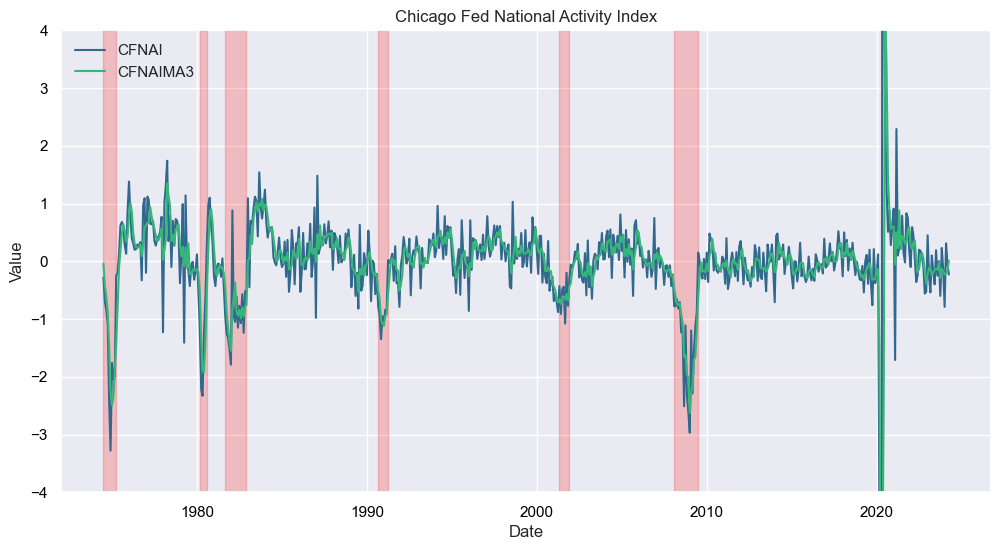

In [104]:
def fetch_recession_periods(usrec, start_date, end_date):
    recessions = {}
    recession_num = 0
    start = None
    for i in range(len(usrec)):
        if usrec.iloc[i, 0] == 1:  
            if start is None:  
                start = usrec.index[i]  
                start = datetime(start.year, start.month, calendar.monthrange(start.year, start.month)[1])
            end = usrec.index[i]
            end = datetime(end.year, end.month, calendar.monthrange(end.year, end.month)[1])
        elif start is not None:  
            recession_num += 1
            recessions[recession_num] = {'start': start.strftime('%Y-%m-%d'), 'end': end.strftime('%Y-%m-%d')}
            start = None  
    if start is not None:
        recession_num += 1
        recessions[recession_num] = {'start': start.strftime('%Y-%m-%d'), 'end': end.strftime('%Y-%m-%d')}
    if usrec.iloc[0, 0] == 1:
        first_start = usrec.index[0] - pd.offsets.MonthBegin(1)
        first_start = datetime(first_start.year, first_start.month, calendar.monthrange(first_start.year, first_start.month)[1])
        recessions[1]['start'] = first_start.strftime('%Y-%m-%d')
    return recessions

def add_recession_bands(ax, recessions, start_date, end_date):
    plot_start_date = pd.to_datetime(start_date)
    plot_end_date = pd.to_datetime(end_date)
    for rec_num, rec_dates in recessions.items():
        rec_start_date = pd.to_datetime(rec_dates['start'])
        rec_end_date = pd.to_datetime(rec_dates['end'])
        if (rec_start_date <= plot_end_date) and (rec_end_date >= plot_start_date):
            ax.axvspan(rec_start_date, rec_end_date, color="red", alpha=0.2)

def eco_plot(df_data, start_date, end_date, title, y_min, y_max , xline, xupperline, plot=False, save_fig=False):
    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.lineplot(data=df_data, dashes=False, ax=ax, palette="viridis")
        ax.set_title(title)
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.legend(frameon=False, loc = 'upper left')
        ax.tick_params(axis='x', colors='black')  
        ax.tick_params(axis='y', colors='black')  
        recessions = fetch_recession_periods(usrec_data,'1960-01-01', end_date)
        add_recession_bands(ax, recessions, start_date, end_date)
        ax.set_ylim(y_min, y_max)
        plt.axhline(xline, color='black', linestyle='--')
        plt.axhline(xupperline, color='black', linestyle='--')
        if save_fig:
            plt.savefig(f'{end_date}_cf_nai.png', bbox_inches='tight', transparent=False)
        plt.show()
    else:
        return df_data

eco_plot(df_data, start, end, 'Chicago Fed National Activity Index', -4, 4, -100, 100, plot=True, save_fig=False)

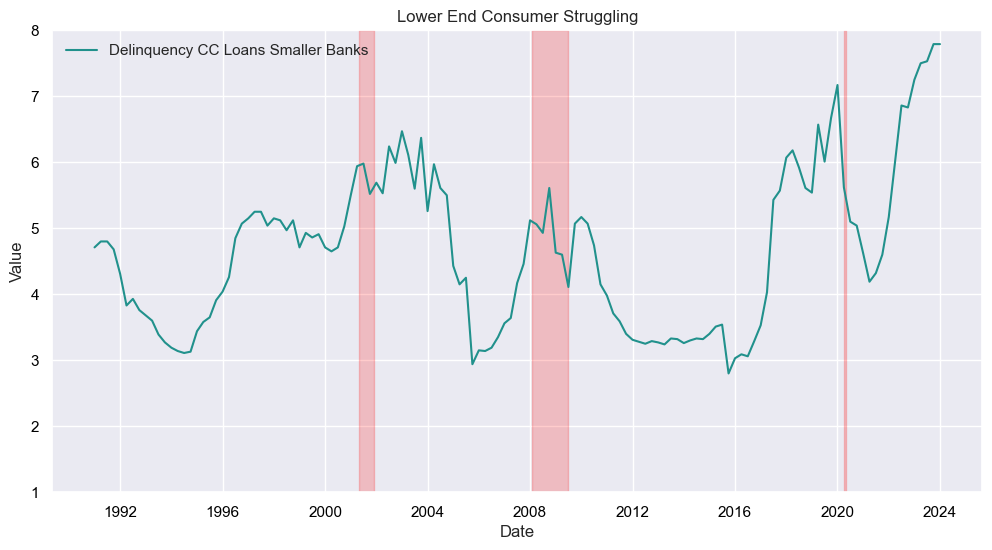

In [105]:
low_end_consumer = ['DRCCLOBS']
start = '1970-01-02'
end = dt.datetime.now()
lec = initial.dataframe(low_end_consumer, data.set_index("DATE"), start, end)
lec = lec.rename(columns = {'DRCCLOBS':'Delinquency CC Loans Smaller Banks'})
eco_plot(lec, '1992-01-01', end, 'Lower End Consumer Struggling', 1, 8, -100, 100, plot=True, save_fig=False)

Kansas City Labor Market Conditions Indicator

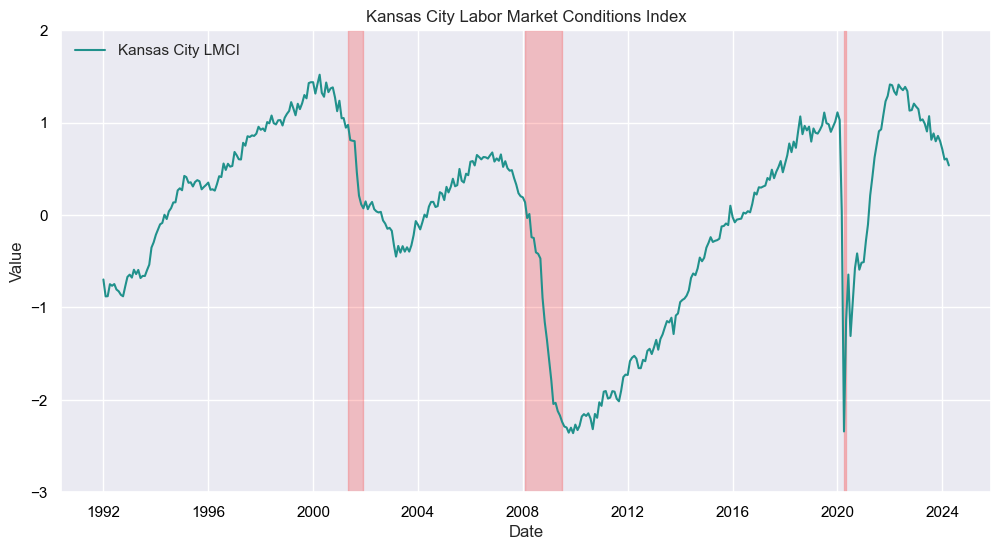

In [106]:
kc = ['FRBKCLMCILA']
start = '1970-01-02'
end = dt.datetime.now()
kclmni = initial.dataframe(kc, data.set_index("DATE"), start, end)
kclmni = kclmni.rename(columns = {'FRBKCLMCILA':'Kansas City LMCI'})
eco_plot(kclmni, '1992-01-01', end, 'Kansas City Labor Market Conditions Index', -3, 2, -100, 100, plot=True, save_fig=False)

In [ ]:
LB0000031Q020SBEA

Senior Loan Officer Survey

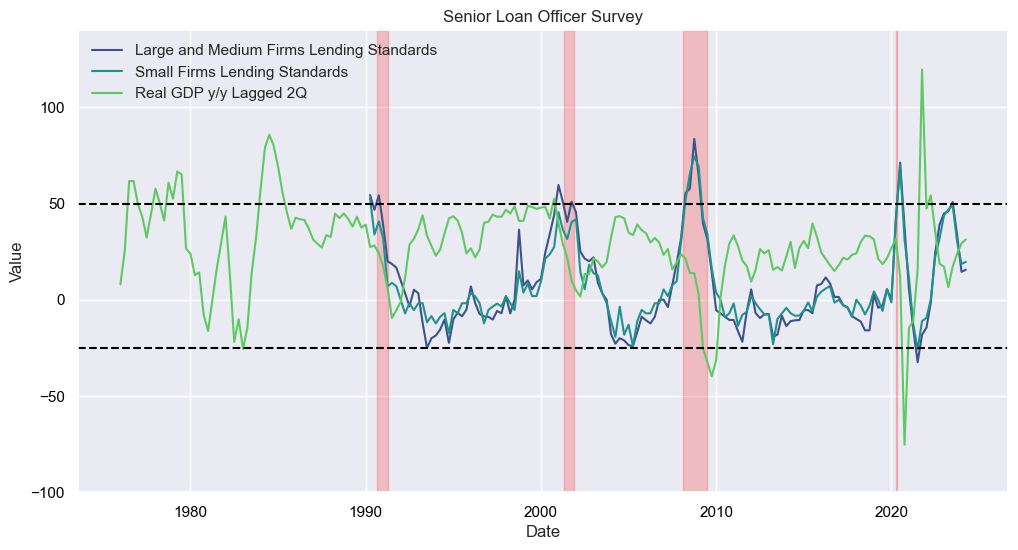

In [107]:
sl = ['DRTSCILM','DRTSCIS','GDPC1']
start = '1970-01-02'
end = dt.datetime.now()
sloos = initial.dataframe(sl, data.set_index("DATE"), start, end)
sloos['rGDP yoy'] = ((sloos['GDPC1'] / sloos['GDPC1'].shift(4)) -1)*1000
sloos['rGDP yoy lag2'] = sloos['rGDP yoy'].shift(2)
sloos = sloos[['DRTSCILM','DRTSCIS','rGDP yoy lag2','rGDP yoy']]
sloos = sloos.rename(columns = {'DRTSCILM':'Large and Medium Firms Lending Standards','DRTSCIS':'Small Firms Lending Standards',
                                'rGDP yoy lag2':'Real GDP y/y Lagged 2Q','rGDP yoy':'Real GDP y/y'})
eco_plot(sloos[['Large and Medium Firms Lending Standards','Small Firms Lending Standards','Real GDP y/y Lagged 2Q']], '1990-01-01', end, 'Senior Loan Officer Survey', -100, 140, -25, 50, plot=True, save_fig=False)

Final Private Sales to Provate Domestic Purchasers

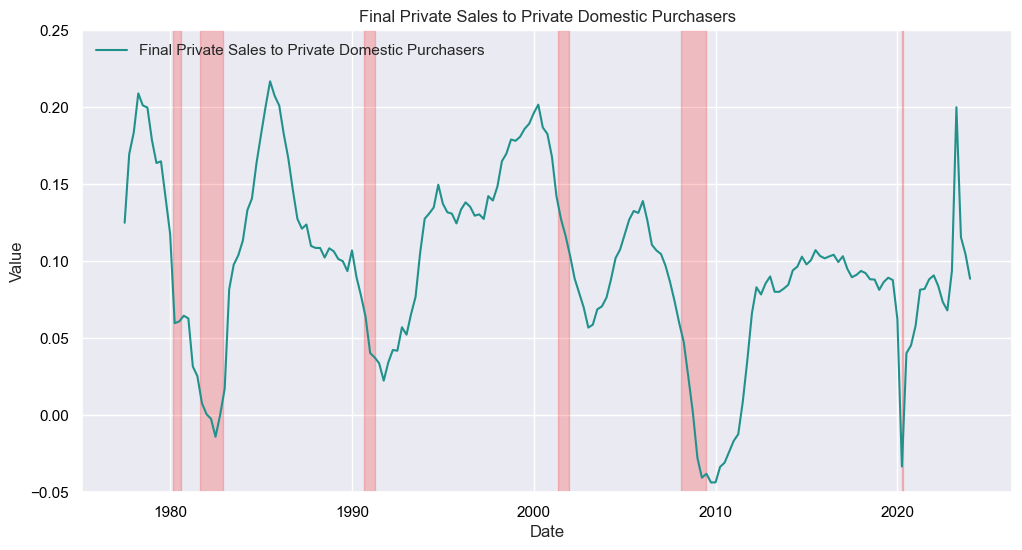

In [108]:
final_sales = ['LB0000031Q020SBEA']
start = '1970-01-02'
end = dt.datetime.now()
fs = initial.dataframe(final_sales, data.set_index("DATE"), start, end)
fs_yoy = (fs / fs.shift(12))-1
fs_yoy.columns = ['Final Private Sales to Private Domestic Purchasers']
eco_plot(fs_yoy, '1975-12-01', end, 'Final Private Sales to Private Domestic Purchasers', -.05, .25, -0.5, 0.5, plot=True, save_fig=False)

Coincident Indicator

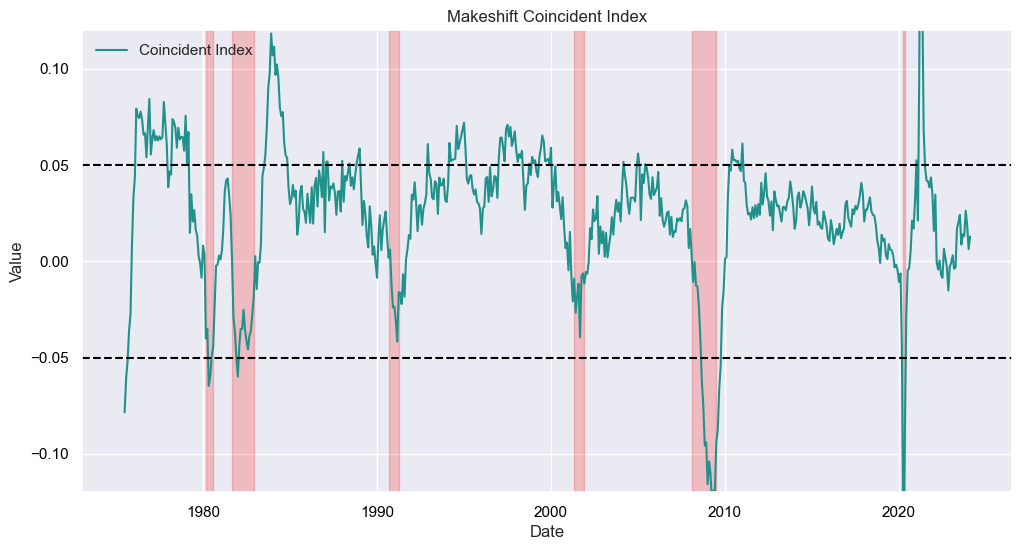

In [109]:
coinc = ['CMRMTSPL','INDPRO','W875RX1','PAYEMS']
start = '1970-01-02'
end = dt.datetime.now()
coincident = initial.dataframe(coinc, data.set_index("DATE"), start, end)
own = coincident.mean(axis=1).iloc[:-2]
own_yoy = (own / own.shift(12))-1
own_yoy = pd.DataFrame(own_yoy).dropna()
own_yoy.columns = ['Coincident Index']
eco_plot(own_yoy, '1975-12-01', end, 'Makeshift Coincident Index', -.12, .12, -0.05, 0.05, plot=True, save_fig=False)

Spending on Durable Goods

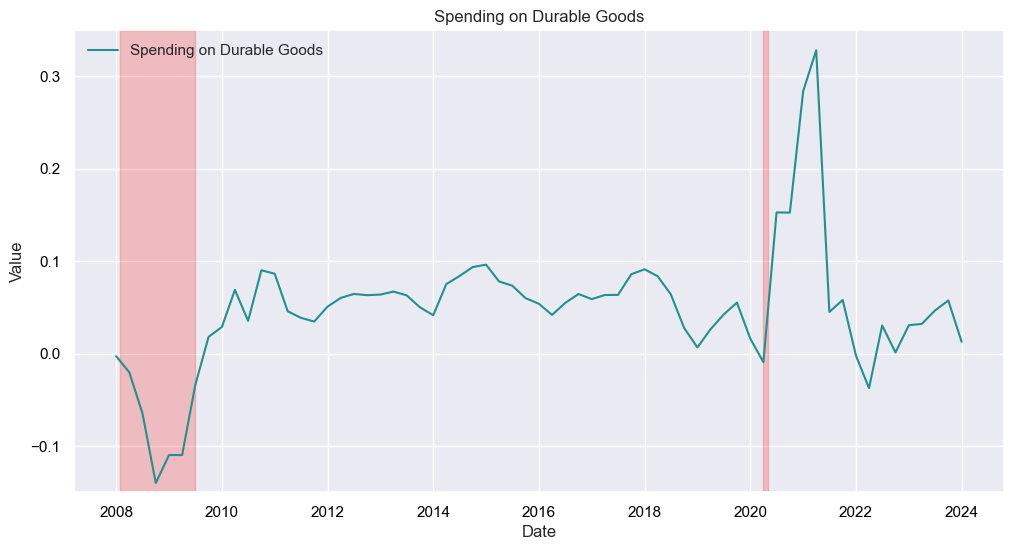

In [110]:
equip = ['PCDGCC96']
start = '2007-01-01'
end = dt.datetime.now()
durable = initial.dataframe(equip, data.set_index("DATE"), start, end)
durable_yoy = (durable / durable.shift(4))-1
durable_yoy.columns = ['Spending on Durable Goods']
eco_plot(durable_yoy, '2007-01-01', end, 'Spending on Durable Goods', -.15, .35, -5, 5, plot=True, save_fig=False)

GDP and GDI Average

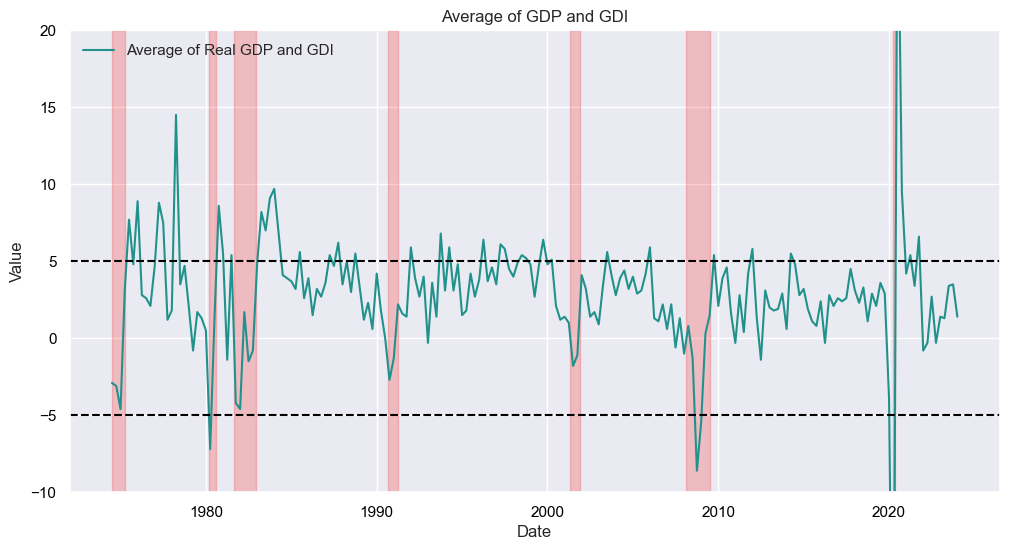

In [111]:
gdp = ['PB0000091Q225SBEA']
start = '1950-01-01'
end = dt.datetime.now()
gdp_avg = initial.dataframe(gdp, data.set_index("DATE"), start, end)
gdp_avg = gdp_avg.rename(columns={'PB0000091Q225SBEA':'Average of Real GDP and GDI'})
eco_plot(gdp_avg, '1950-01-01', end, 'Average of GDP and GDI', -10, 20, -5, 5, plot=True, save_fig=False)

Labor Market

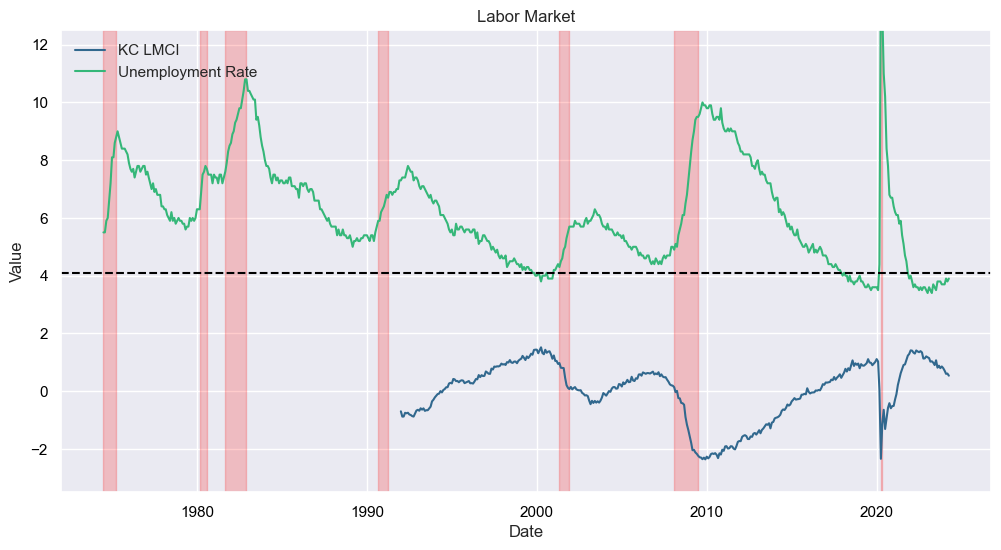

In [112]:
labor = ['UNRATE','FRBKCLMCILA']
start = '1970-01-02'
end = dt.datetime.now()
unemployment = initial.dataframe(labor, data.set_index("DATE"), start, end)
unemployment = unemployment.rename(columns = {'UNRATE':'Unemployment Rate','FRBKCLMCILA':'KC LMCI'})
eco_plot(unemployment, start, end, 'Labor Market', -3.5, 12.5, 4.1, 100, plot=True, save_fig=False)

Michigan Consumer Sentiment Index

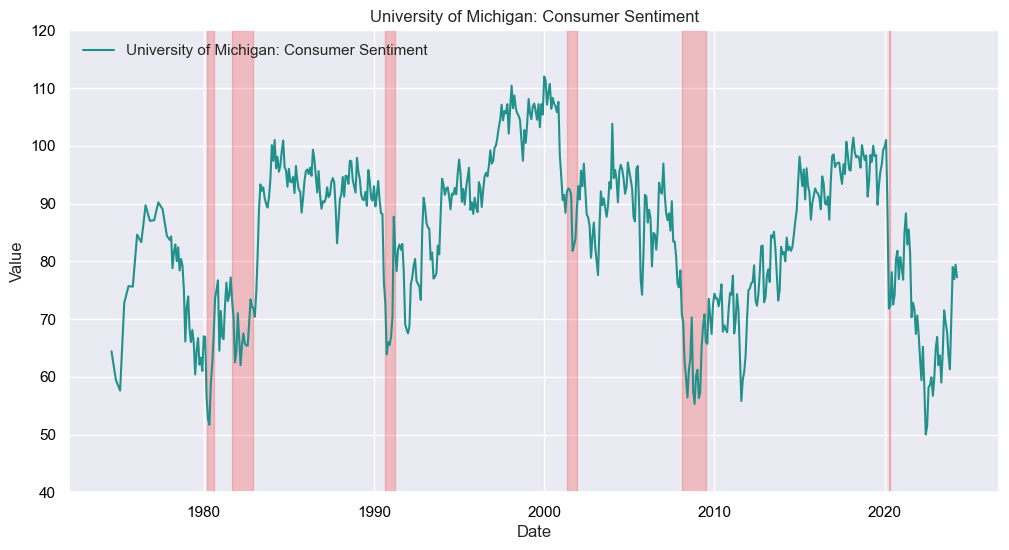

In [113]:
coinc = ['UMCSENT']
start = '1970-01-02'
end = dt.datetime.now()
umc = initial.dataframe(coinc, data.set_index("DATE"), start, end)
umc.columns = ['University of Michigan: Consumer Sentiment']
eco_plot(umc, '1975-12-01', end, 'University of Michigan: Consumer Sentiment', 40, 120, -60, 130, plot=True, save_fig=False)

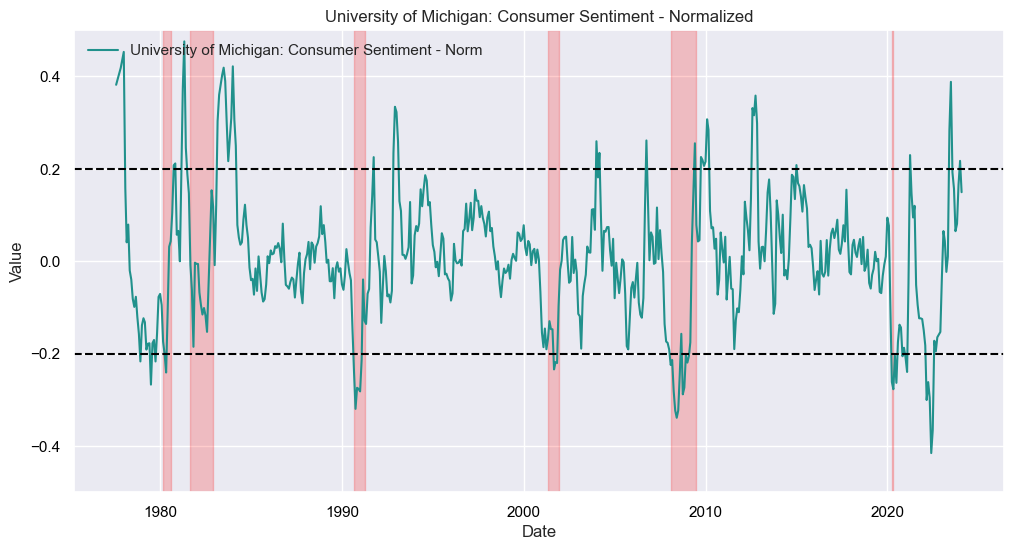

In [114]:
coinc = ['UMCSENT']
start = '1970-01-02'
end = dt.datetime.now()
umc = initial.dataframe(coinc, data.set_index("DATE"), start, end)
own = umc.mean(axis=1).iloc[:-2]
own_yoy = (own / own.shift(12))-1
own_yoy = pd.DataFrame(own_yoy).dropna()
own_yoy.columns = ['University of Michigan: Consumer Sentiment - Norm']
eco_plot(own_yoy, '1975-12-01', end, 'University of Michigan: Consumer Sentiment - Normalized', -0.5, 0.5, -0.2, 0.2, plot=True, save_fig=False)

Average Hourly Earnings (y/y)

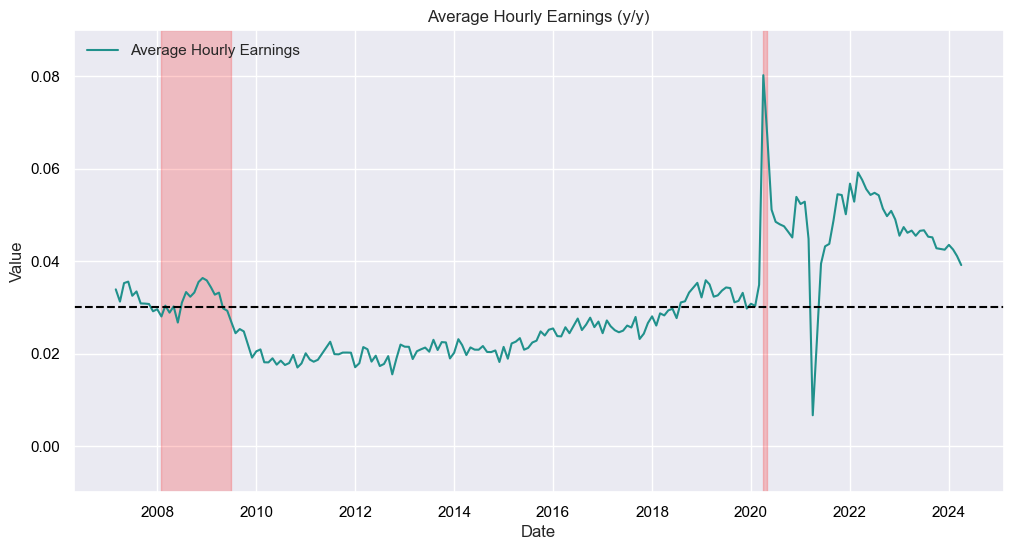

In [120]:
ahe = ['CES0500000003']
start = '1970-01-02'
end = dt.datetime.now()
he = initial.dataframe(ahe, data.set_index("DATE"), start, end).fillna(method='ffill')
he_yoy = ((he / he.shift(12)) - 1).dropna()
he_yoy.columns = ['Average Hourly Earnings']
eco_plot(he_yoy, '2005-01-01', end, 'Average Hourly Earnings (y/y)', -0.01, 0.09, 0.03, 100,plot=True, save_fig=False)

Average Hourly Earnings Annualized (6 month)

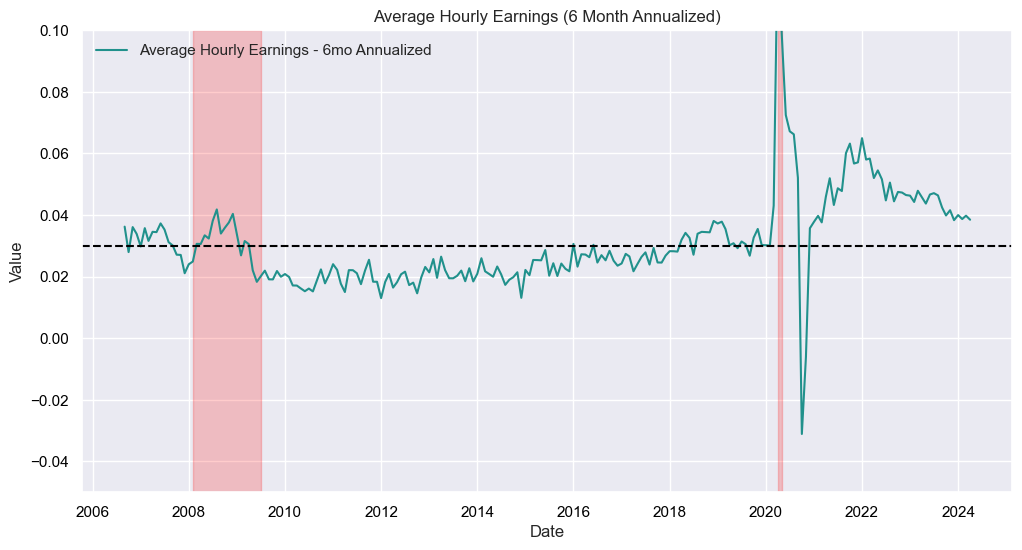

In [121]:
ahe = ['CES0500000003']
start = '1970-01-02'
end = dt.datetime.now()
he = initial.dataframe(ahe, data.set_index("DATE"), start, end).fillna(method='ffill')
he3mo = ((he / he.shift(6))**(12/6) - 1).dropna()
he3mo.columns = ['Average Hourly Earnings - 6mo Annualized']
eco_plot(he3mo, '2005-01-01', end, 'Average Hourly Earnings (6 Month Annualized)', -0.05, 0.1, 0.03, 100, plot=True, save_fig=False)

Average Hourly Earnings Annualized (3 month)

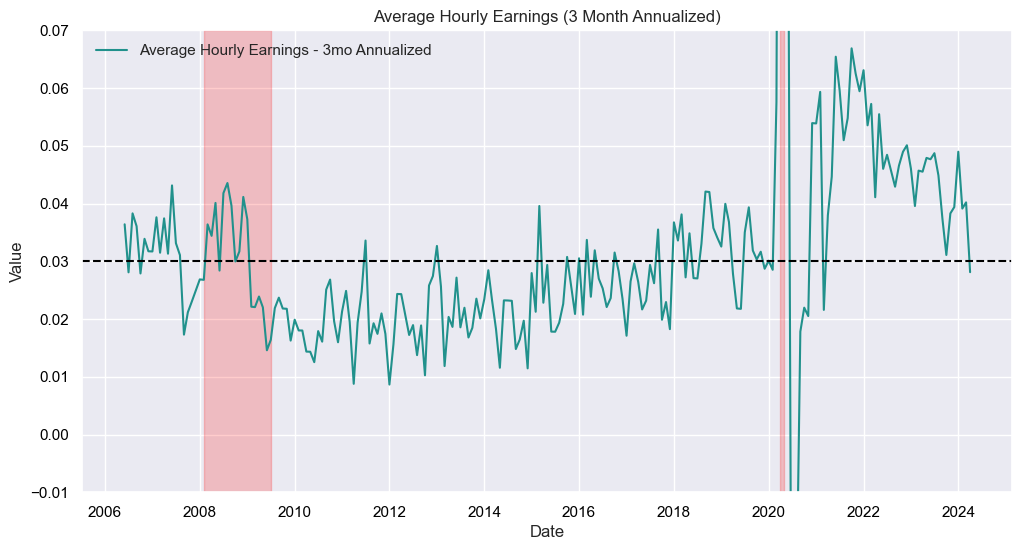

In [122]:
ahe = ['CES0500000003']
start = '1970-01-02'
end = dt.datetime.now()
he = initial.dataframe(ahe, data.set_index("DATE"), start, end).fillna(method='ffill')
he3mo = ((he / he.shift(3))**(12/3) - 1).dropna()
he3mo.columns = ['Average Hourly Earnings - 3mo Annualized']
eco_plot(he3mo, '2005-01-01', end, 'Average Hourly Earnings (3 Month Annualized)', -0.01, 0.07, 0.03, 100, plot=True, save_fig=False)

Average Hourly Earnings to CPI Services less Housing

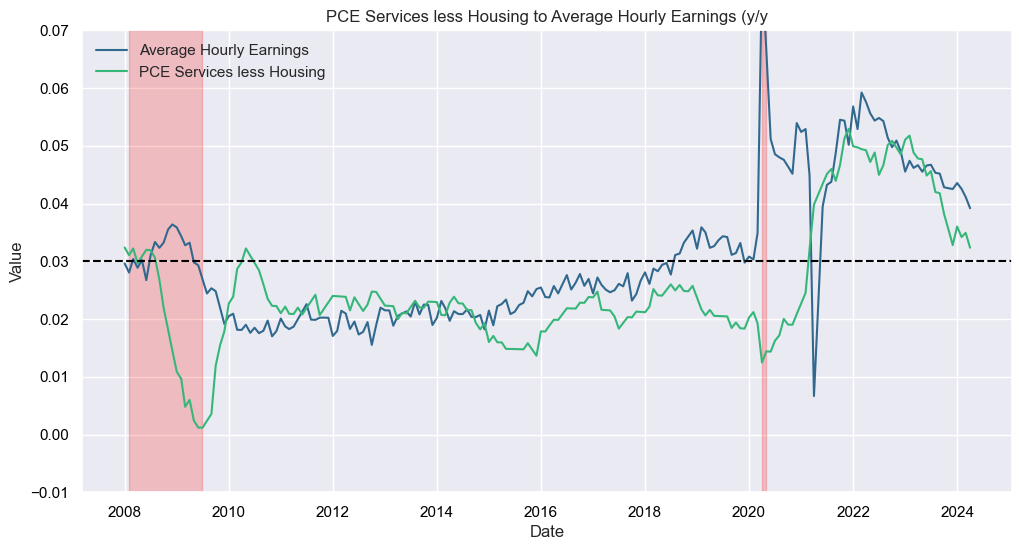

In [126]:
all = ['CES0500000003','IA001260M']
start = '2007-01-01'
end = dt.datetime.now()
he = initial.dataframe(all, data.set_index("DATE"), start, end).fillna(method='ffill')
he_yoy = ((he / he.shift(12)) - 1).dropna()
he_yoy = he_yoy.rename(columns = {'CES0500000003':'Average Hourly Earnings','IA001260M':'PCE Services less Housing'})
eco_plot(he_yoy, '2007-01-01', end, 'PCE Services less Housing to Average Hourly Earnings (y/y', -0.01, 0.07, 0.03, 100, plot=True, save_fig=False)

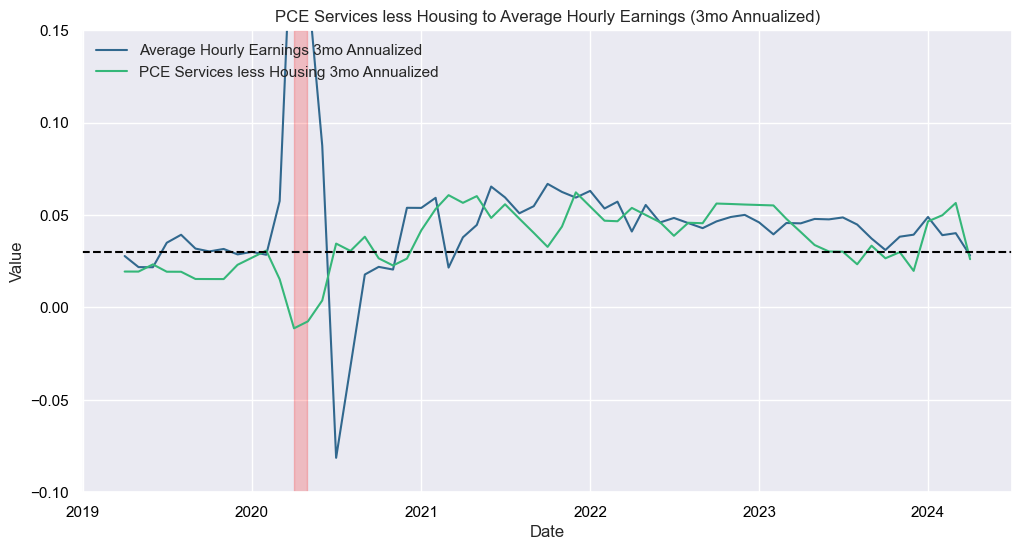

In [128]:
all = ['CES0500000003','IA001260M']
start = '2019-01-01'
end = dt.datetime.now()
he = initial.dataframe(all, data.set_index("DATE"), start, end).fillna(method='ffill')
he_yoy = ((he / he.shift(3))**(12/3) - 1).dropna()
he_yoy = he_yoy.rename(columns = {'CES0500000003':'Average Hourly Earnings 3mo Annualized','IA001260M':'PCE Services less Housing 3mo Annualized'})
eco_plot(he_yoy, '2019-01-01', end, 'PCE Services less Housing to Average Hourly Earnings (3mo Annualized)', -0.10, 0.15, 0.03, 100, plot=True, save_fig=False)

Sahm Rule (U3)

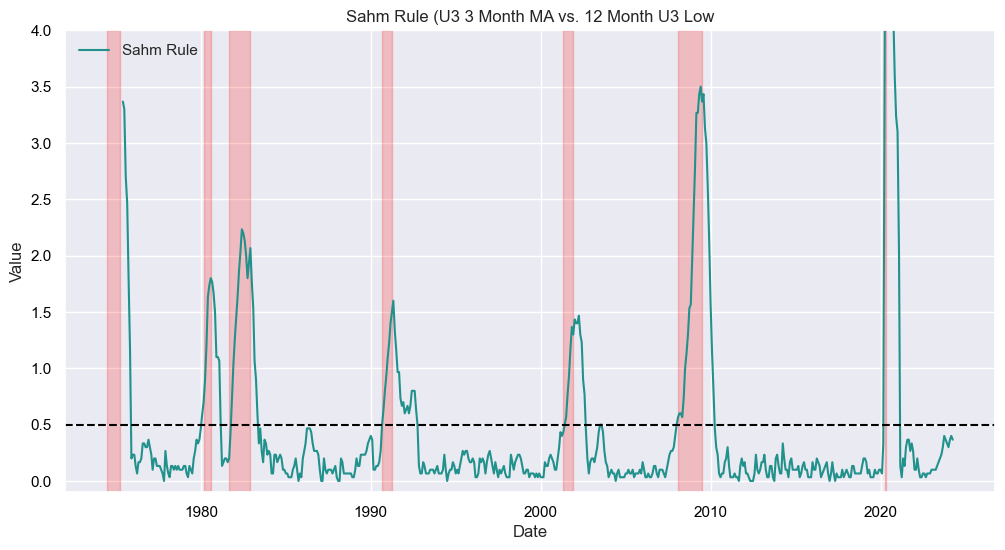

In [18]:
labor = ['UNRATE']
start = '1970-01-02'
end = dt.datetime.now()
unemployment = initial.dataframe(labor, data.set_index("DATE"), start, end)
unemployment = unemployment.rename(columns = {'UNRATE':'U3 Unemployment Rate'})
unemployment = unemployment.fillna(method='ffill')
unemployment['3mo Moving Average'] = unemployment['U3 Unemployment Rate'].rolling(window = 3).mean()
unemployment['Lowest 12 Month'] = unemployment['U3 Unemployment Rate'].rolling(window = 12).min()
unemployment['Sahm Rule'] = unemployment['3mo Moving Average'] - unemployment['Lowest 12 Month']
unemployment = unemployment.dropna()
eco_plot(unemployment[['Sahm Rule']], start, end, 'Sahm Rule (U3 3 Month MA vs. 12 Month U3 Low', -0.1, 4, 0.5, 100, plot=True, save_fig=False)

Beveridge Curve

Phillips Curve

Python Good Finance

Dow Jones Earnings

VIX

In [17]:
main = Trading(0, "2018-01-01", "2020-01-01")   # set first input to one if you want exact date inputs
df, df1, df2 = main.yahoo_universe()            # dont have to run this everytime
main.trading_sql(df) 

Updating the sql table was a success


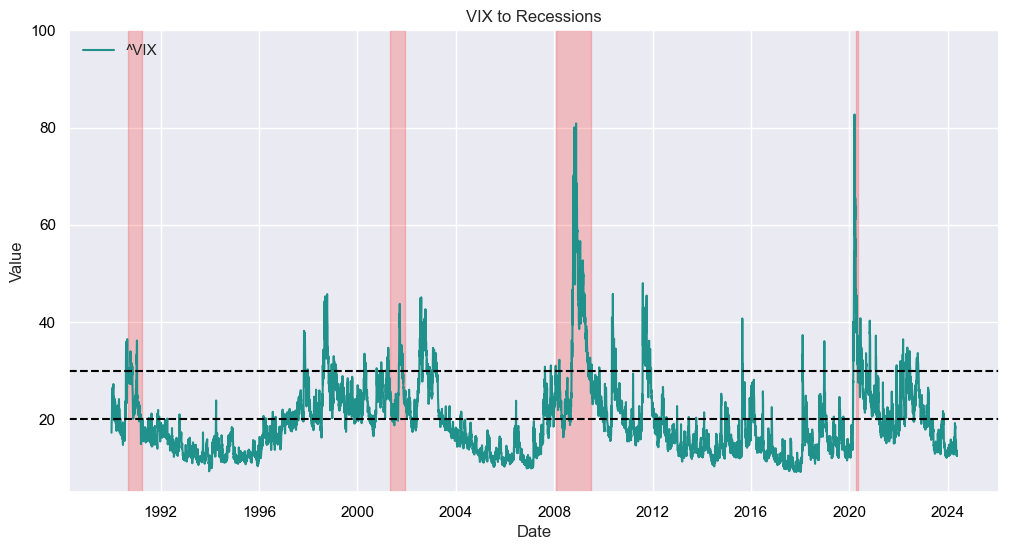

In [18]:
final = main.load_sql().set_index("Date")
tickers =["^VIX"]
start = '1990-01-01'
end = '2024-05-15'
dfcap = main.dataframe(tickers, final, start, end)
dfcap = dfcap.dropna()
dfcap.index = pd.to_datetime(dfcap.index)
daily = dfcap.copy()
end = dt.datetime.now()
eco_plot(daily, '1990', end, 'VIX to Recessions', 5, 100, 30, 20, plot=True, save_fig=False)

SP500

In [19]:
final = main.load_sql().set_index("Date")
tickers =["SPY"]
start = '1990-01-01'
end = '2024-05-02'
dfcap = main.dataframe(tickers, final, start, end)
dfcap = dfcap.dropna()
dfcap.index = pd.to_datetime(dfcap.index)
daily = dfcap.copy()
mo4 = daily.pct_change(63)

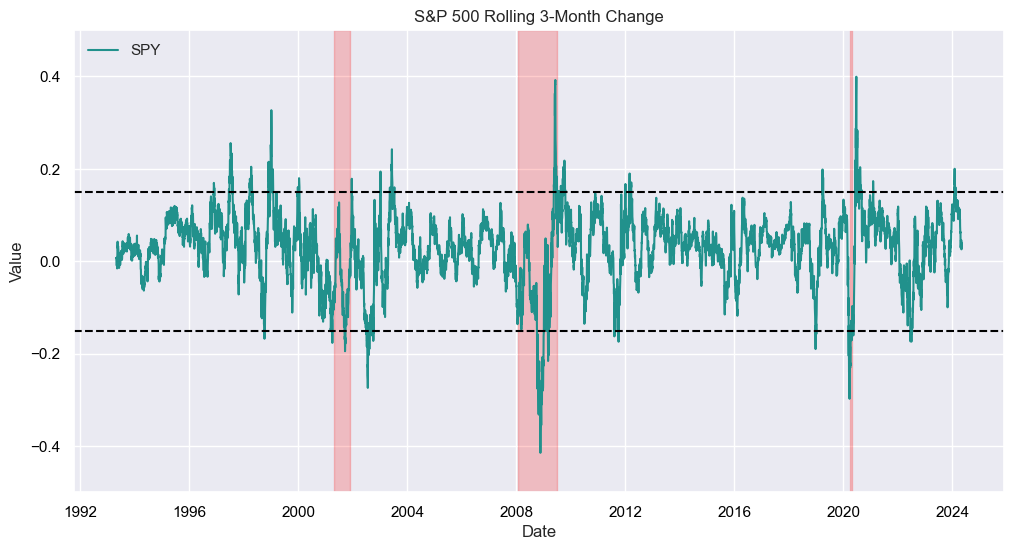

In [20]:
end = dt.datetime.now()
eco_plot(mo4, '1994-01-02', end, 'S&P 500 Rolling 3-Month Change', -.5, .5, -0.15, 0.15, plot=True, save_fig=False)

Personal Savings Rate

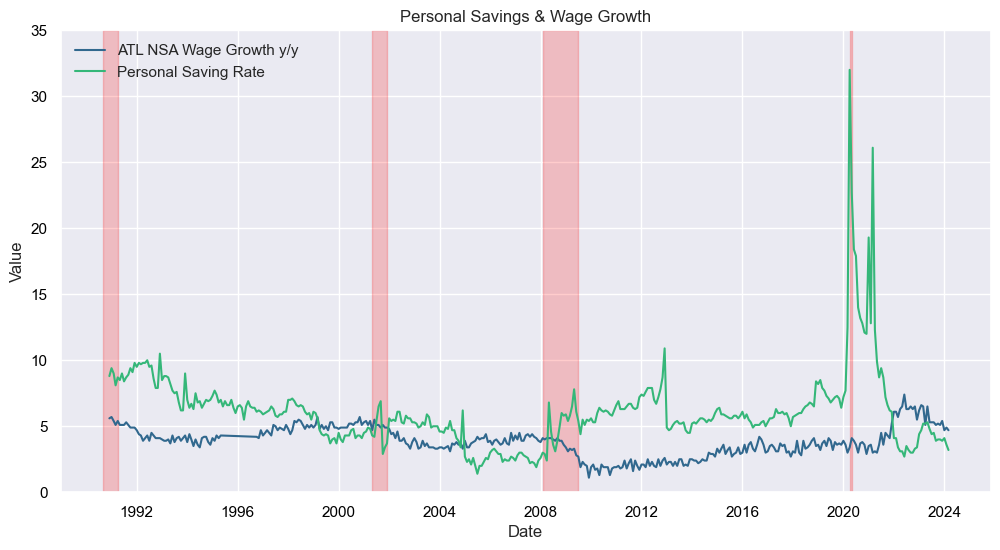

In [26]:
tickers = ['PSAVERT','FRBATLWGTUMHWG83O']
start = '1990-12-01'
end = dt.datetime.now()
savings_rate = initial.dataframe(tickers, data.set_index("DATE"), start, end)
savings_rate = savings_rate.rename(columns = {"PSAVERT":"Personal Saving Rate","FRBATLWGTUMHWG83O":"ATL NSA Wage Growth y/y"})
eco_plot(savings_rate, '1990-12-01', end, 'Personal Savings & Wage Growth', 0, 35, -1,-1,plot=True, save_fig=False)

Core CPI 3mo Annualized

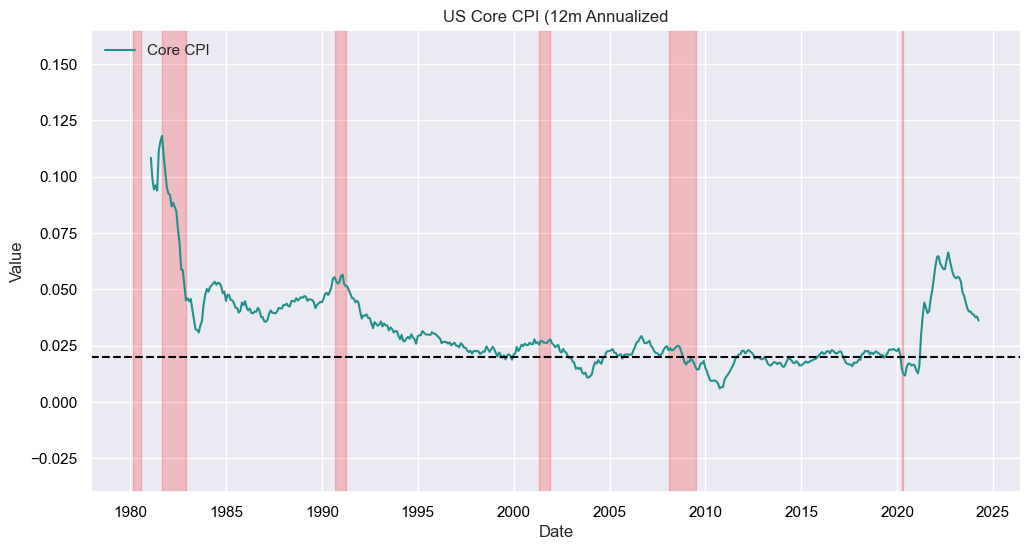

In [27]:
tickers = ['CPILFESL']
start = '1980-01-02'
end = dt.datetime.now()
core_cpi = initial.dataframe(tickers, data.set_index("DATE"), start, end)
core_cpi = core_cpi.rename(columns = {"CPILFESL":"Core CPI"})
cpi_3mo_annualized = ((core_cpi / core_cpi.shift(12)) - 1).dropna()
eco_plot(cpi_3mo_annualized, start, end, 'US Core CPI (12m Annualized', -.04, .165,0.02, 0.19, plot=True, save_fig=False)

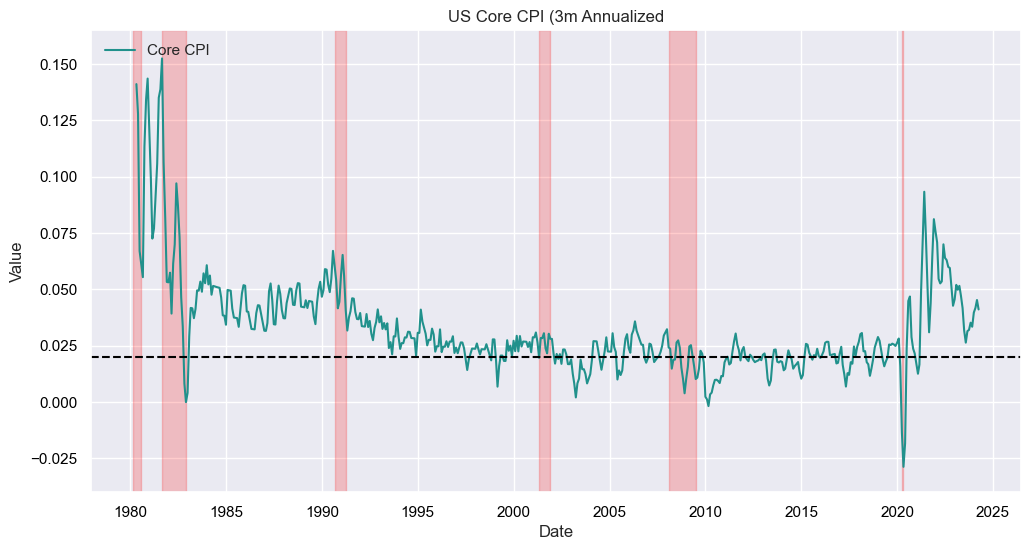

In [47]:
tickers = ['CPILFESL']
start = '1980-01-02'
end = dt.datetime.now()
core_cpi = initial.dataframe(tickers, data.set_index("DATE"), start, end)
core_cpi = core_cpi.rename(columns = {"CPILFESL":"Core CPI"})
cpi_3mo_annualized = ((core_cpi / core_cpi.shift(3))**(12/3) - 1).dropna()
eco_plot(cpi_3mo_annualized, start, end, 'US Core CPI (3m Annualized', -.04, .165,0.02, 0.19, plot=True, save_fig=False)

PCE

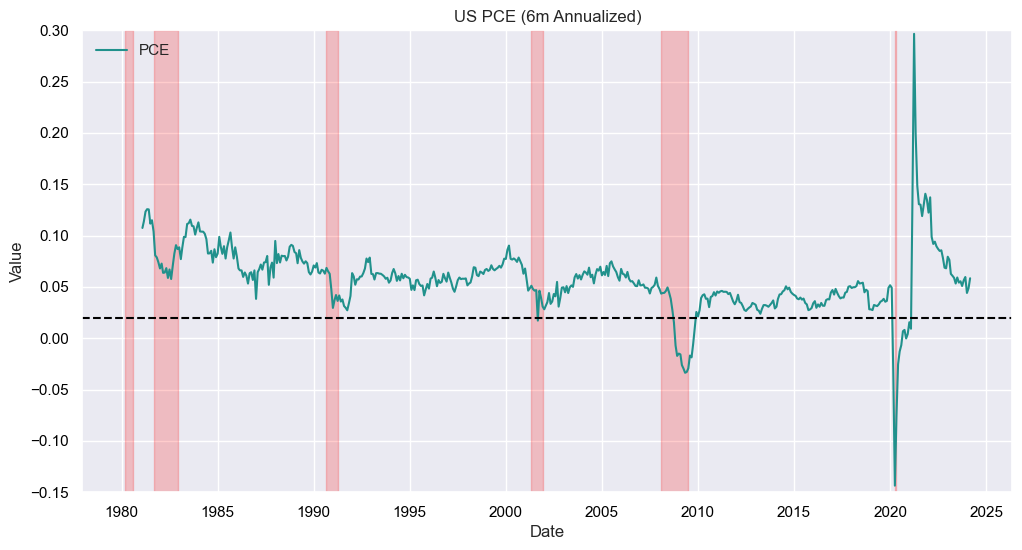

In [31]:
tickers = ['PCE']
start = '1980-01-02'
end = dt.datetime.now()
pce = initial.dataframe(tickers, data.set_index("DATE"), start, end)
pce = pce.rename(columns = {"PCE":"PCE"})
# pce_3mo_annualized = ((pce / pce.shift(6))**(12/6) - 1).dropna()
pce_3mo_annualized = ((pce / pce.shift(12)) - 1).dropna()
eco_plot(pce_3mo_annualized, start, end, 'US PCE (6m Annualized)', -.15, .3, .02, 100, plot=True, save_fig=False)

Core PCE

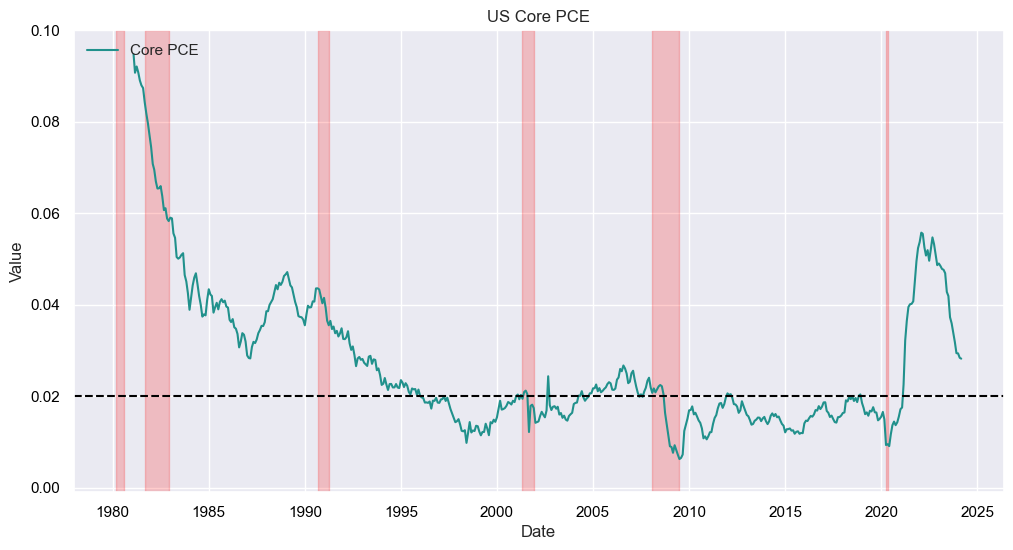

In [41]:
tickers = ['PCEPILFE']
start = '1980-01-02'
end = dt.datetime.now()
pce = initial.dataframe(tickers, data.set_index("DATE"), start, end)
pce = pce.rename(columns = {"PCEPILFE":"Core PCE"})
pce_annualized = ((pce / pce.shift(12)) - 1).dropna()
# pce_3mo_annualized = ((pce / pce.shift(12)) - 1).dropna()
eco_plot(pce_annualized, start, end, 'US Core PCE', -.001, .1, .02, 100, plot=True, save_fig=False)

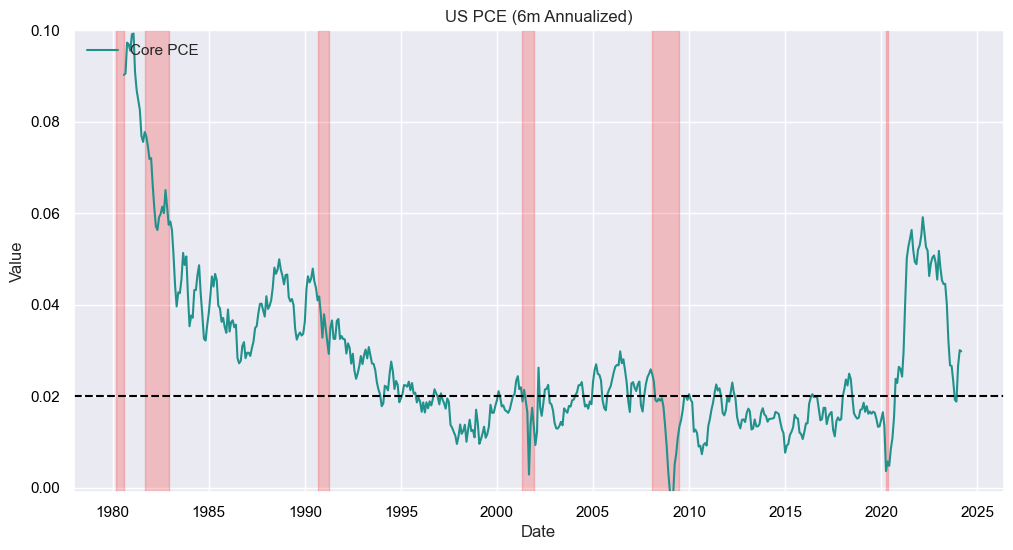

In [40]:
tickers = ['PCEPILFE']
start = '1980-01-02'
end = dt.datetime.now()
pce = initial.dataframe(tickers, data.set_index("DATE"), start, end)
pce = pce.rename(columns = {"PCEPILFE":"Core PCE"})
pce_6mo_annualized = ((pce / pce.shift(6))**(12/6) - 1).dropna()
# pce_3mo_annualized = ((pce / pce.shift(12)) - 1).dropna()
eco_plot(pce_6mo_annualized, start, end, 'US PCE (6m Annualized)', -.001, .1, .02, 100, plot=True, save_fig=False)

Real Personal Income less Transfer Payments

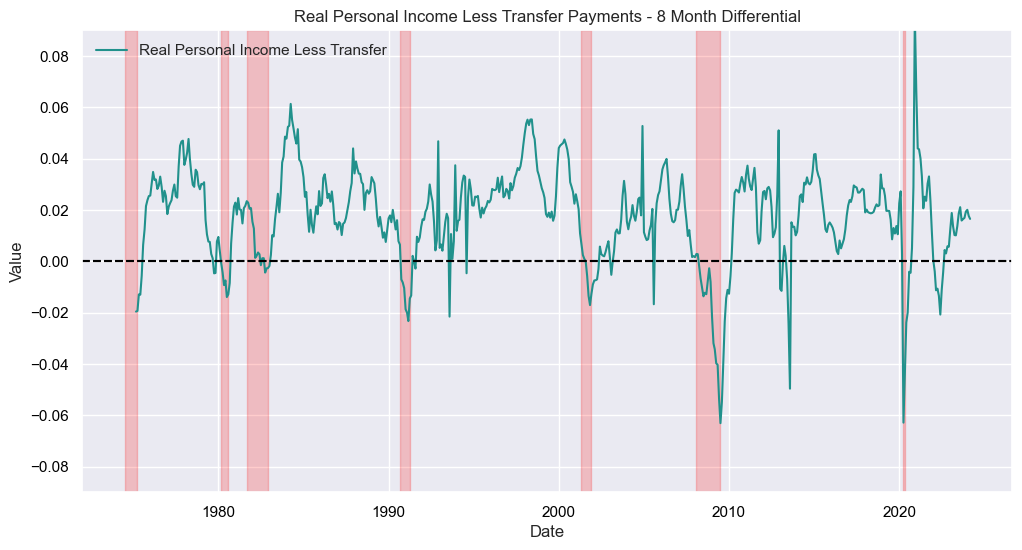

In [284]:
tickers = ['W875RX1']
start = '1960-01-02'
end = dt.datetime.now()
pi_less = initial.dataframe(tickers, data.set_index("DATE"), start, end)
pi_less = pi_less.rename(columns = {'W875RX1':'Real Personal Income Less Transfer'})
pi_less = ((pi_less/pi_less.shift(8))-1).dropna()
eco_plot(pi_less, start, end, 'Real Personal Income Less Transfer Receipts - 8 Month Differential', -0.09, 0.09,0,0,plot=True, save_fig=False)

ECI

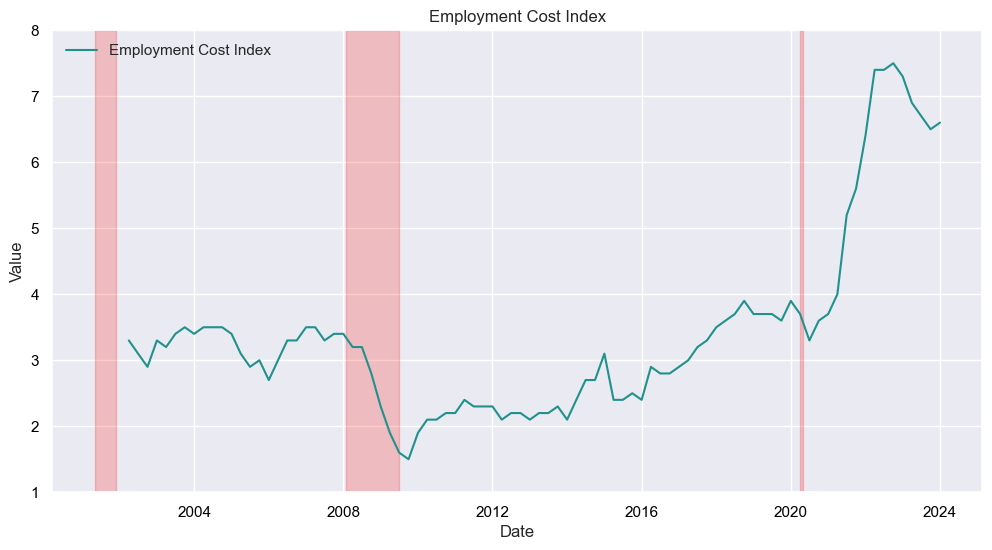

In [50]:
tickers = ['ECIALLCIV']
start = '2001-01-02'
end = dt.datetime.now()
eci = initial.dataframe(tickers, data.set_index("DATE"), start, end)
eci = eci.rename(columns = {"ECIALLCIV":"Employment Cost Index"})
eci_yoy = eci - eci.shift(4)
eco_plot(eci_yoy, start, end, 'Employment Cost Index', 1, 8,0,0,plot=True, save_fig=False)

5yr Inflation Swap

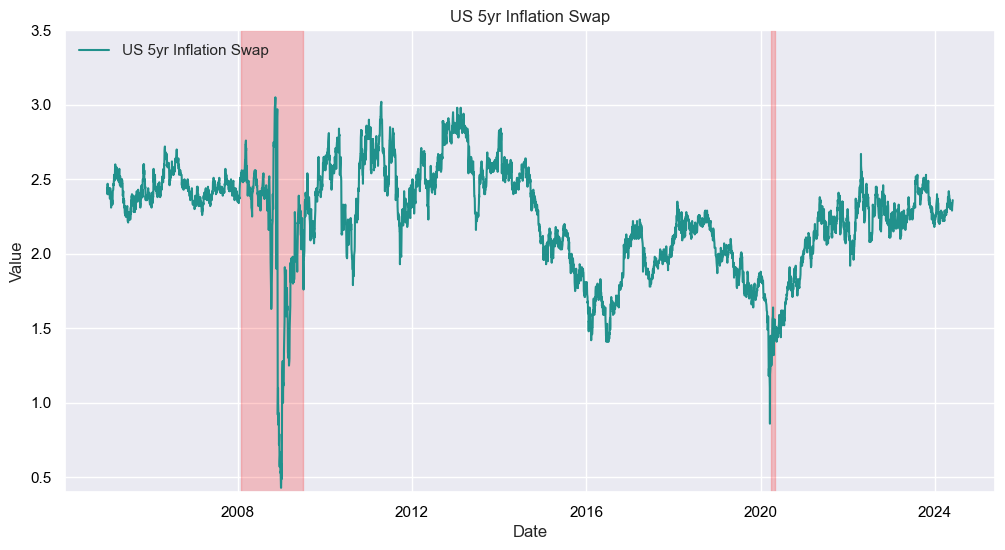

In [54]:
tickers = ['T5YIFR']
start = '2005-01-02'
end = dt.datetime.now()
inf_swap = initial.dataframe(tickers, data.set_index("DATE"), start, end)
inf_swap = inf_swap.rename(columns = {"T5YIFR":"US 5yr Inflation Swap"})
# pce_yoy = pce.pct_change()
eco_plot(inf_swap, start, end, 'US 5yr Inflation Swap', 0.4, 3.5, 0,0,plot=True, save_fig=False)

10 Year Treasury Moving Average

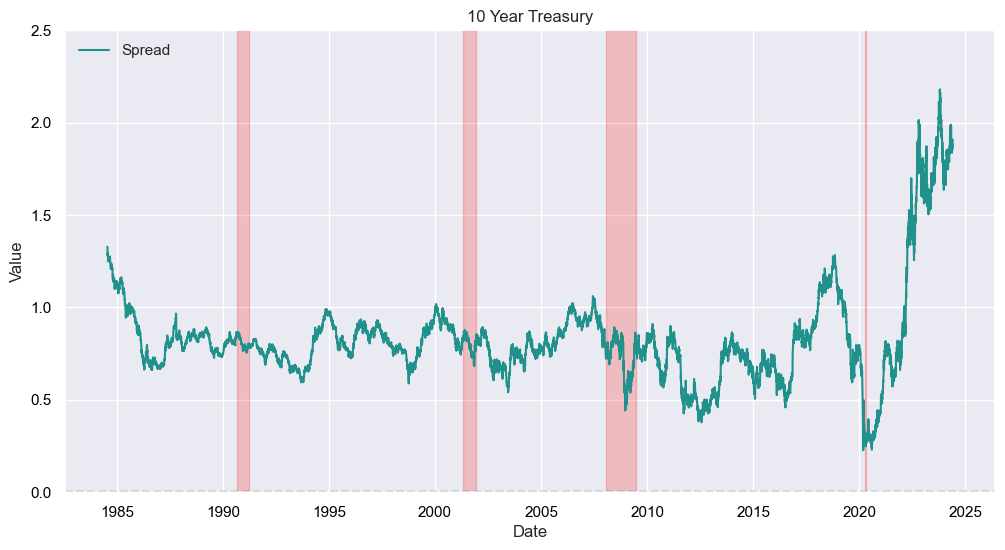

In [56]:
tickers = ['DGS10']
start = '1960-01-02'
end = dt.datetime.now()
rates = initial.dataframe(tickers, data.set_index("DATE"), start, end)
rates = rates.rename(columns = {"DGS10":"10 Year Treasury"})
rates['10 year Treasury Moving Average'] = rates['10 Year Treasury'].rolling(window=252*10).mean()
rates['Spread'] = rates['10 Year Treasury'] / rates['10 year Treasury Moving Average']
# pce_yoy = pce.pct_change()
eco_plot(rates[['Spread']], '1983', end, '10 Year Treasury', 0, 2.5, 0,0,plot=True, save_fig=False)

In [57]:
tickers = ['PSAVERT','FRBATLWGTUMHWG83O']
start = '1990-01-02'
end = dt.datetime.now()
savings_rate = initial.dataframe(tickers, data.set_index("DATE"), start, end)

In [58]:
savings_rate.columns = ['Personal Saving Rate','Median Hourly Wage Growth']
fig = px.line(savings_rate['1990':].dropna().reset_index(), x="DATE", y=["Personal Saving Rate", "Median Hourly Wage Growth"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Personal Savings Rate')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Personal Savings Rate %"
)

In [59]:
tickers = ['PI']
start = '1990-01-02'
end = dt.datetime.now()
personal_income = initial.dataframe(tickers, data.set_index("DATE"), start, end)
pi_yoy = (personal_income / personal_income.shift(12))-1
pi_yoy = pi_yoy.dropna()

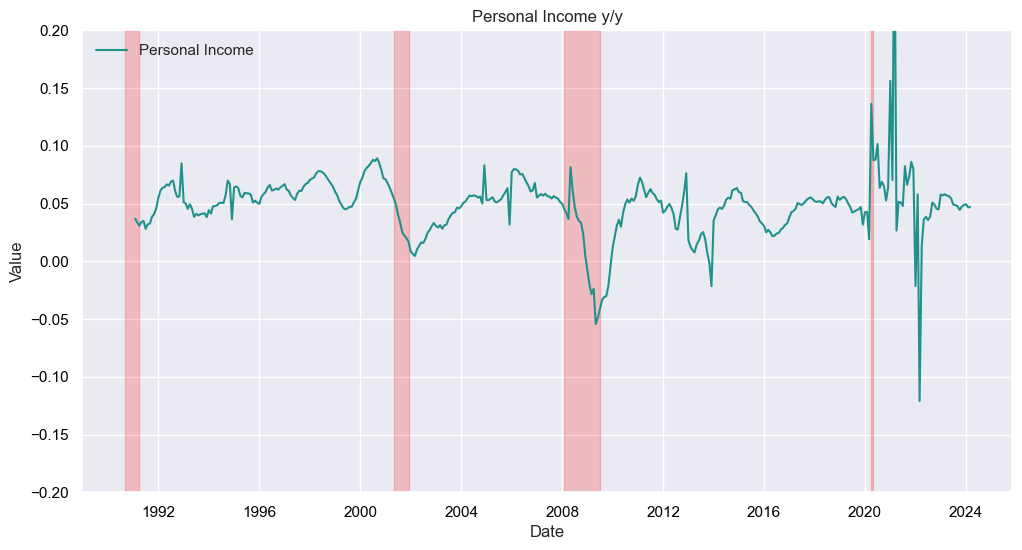

In [248]:
eco_plot(pi_yoy, '1990', end, 'Personal Income y/y', -.20, .20, -4,-3,plot=True, save_fig=False)

In [61]:
pi_yoy.columns = ['Personal Income']
fig = px.line(pi_yoy['1990':].dropna().reset_index(), x="DATE", y=["Personal Income"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Personal Income Back to Pre-Covid Trend')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Personal Income"
)

Hires and Wages

In [62]:
tickers = ['FRBATLWGTUMHWG83O','UNRATE','TEMPHELPS','JTSHIR']
start = '1990-01-02'
end = dt.datetime.now()
unrate = initial.dataframe(tickers, data.set_index("DATE"), start, end)

In [63]:
workforce = unrate[['FRBATLWGTUMHWG83O','JTSHIR']].dropna()
wf = workforce.rename(columns = {'FRBATLWGTUMHWG83O':'ATL Fed Wage Tracker',
                            'JTSHIR':'NFP: Hires'})
fig = px.line(wf.reset_index(), x="DATE", y=["NFP: Hires","ATL Fed Wage Tracker"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Hires and Wages')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Hires and Wages: Levels")

Prime Age Employment to Demand 

In [64]:
tickers = ['LNS12300060','LNS11324230']
start = '1990-01-02'
end = dt.datetime.now()
age_participation = initial.dataframe(tickers, data.set_index("DATE"), start, end)

In [65]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots
age_participation.columns = ['Participation 25-54','Participation 55+']

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=age_participation.index, y=age_participation['Participation 25-54'], name="25-54"),
    secondary_y=False,)
fig.add_trace(
    go.Scatter(x=age_participation.index, y=age_participation['Participation 55+'], name="55+"),
    secondary_y=True,)
fig.update_layout(
    title_text="Labor Participation Rate: Shortage Led to Surge in Wages",
    width=800,
    height=800)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="<b>55+</b> Participation Rate", secondary_y=False)
fig.update_yaxes(title_text="<b>25-54</b> Participation Rate", secondary_y=True)
fig.show()

Taking Yields at Top

In [66]:
tickers = ['EFFR','BAMLC0A4CBBBEY']
start = '1990-01-02'
end = dt.datetime.now()
ff = initial.dataframe(tickers, data.set_index("DATE"), start, end)

In [67]:
ff = ff.rename(columns={'EFFR':'Federal Funds','BAMLC0A4CBBBEY':'BBB Yields'})
fig = px.line(ff['1990':].dropna().reset_index(), x="DATE", y=["Federal Funds","BBB Yields"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Fed Funds to BBB Yields')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="bps"
)

Personal Savings Dwindling as Wages Normalize

In [68]:
tickers = ['PMSAVE','FRBATLWGTUMHWG83O']
start = '1990-01-02'
end = dt.datetime.now()
savings_to_wages = initial.dataframe(tickers, data.set_index("DATE"), start, end)

In [69]:
savings_to_wages = savings_to_wages.rename(columns={'FRBATLWGTUMHWG83O':'ATL Fed Wages','PMSAVE':'Personal Savings'})
savings_to_wages['Personal Savings divided by 100'] = savings_to_wages['Personal Savings']/100
fig = px.line(savings_to_wages['1990':].dropna().reset_index(), x="DATE", y=['ATL Fed Wages','Personal Savings divided by 100'],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Normalizing Wages and Dwindling Savings')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title=" "
)

Job Openings to Unemployment Rate - Inverse (As job openings decline, Unemployment rate ticks up)

In [72]:
tickers = ['JTSJOL','UNRATE']
start = '1990-01-02'
end = dt.datetime.now()
openings_to_unemployment = initial.dataframe(tickers, data.set_index("DATE"), start, end)

In [73]:
openings_to_unemployment = openings_to_unemployment.rename(columns = {'JTSJOL':'Job Openings','UNRATE':'Unemployment Rate'})

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=openings_to_unemployment.index, y=openings_to_unemployment['Job Openings'], name="Job Openings"),
    secondary_y=False,)
fig.add_trace(
    go.Scatter(x=openings_to_unemployment.index, y=openings_to_unemployment['Unemployment Rate'], name="Unemployment Rate"),
    secondary_y=True,)
fig.update_layout(
    title_text="Job Openings Realtionship with Unemployment Rate",
    width=800,
    height=800)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="<b>Job Openings</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Unemployment Rate</b>", secondary_y=True)
fig.show()

Inverted Yield Curve 

In [74]:
tickers = ['T10Y3M']
start = '1990-01-02'
end = dt.datetime.now()
invert = initial.dataframe(tickers, data.set_index("DATE"), start, end)

In [75]:
invert.columns = ['10yr Minus 3mo']
fig = px.line(invert['1990':].dropna().reset_index(), x="DATE", y=['10yr Minus 3mo'],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Inverted Yield Curve since November 2022')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title=" ")

Coincident Index is a Better Measure - CLI has been down for 21 months now 

In [76]:
tickers = ['CMRMTSPL','INDPRO','W875RX1','PAYEMS']
start = '1990-01-02'
end = dt.datetime.now()
coincident = initial.dataframe(tickers, data.set_index("DATE"), start, end)
own = coincident.mean(axis=1).iloc[:-2]
own_yoy = (own / own.shift(12))-1
own_yoy = pd.DataFrame(own_yoy).dropna()
own_yoy.columns = ['Makeshift Coincident Index']


In [77]:
tickers = ['GDPC1']
start = '1990-01-02'
end = dt.datetime.now()
gdp = initial.dataframe(tickers, data.set_index("DATE"), start, end)
rgdp = (gdp / gdp.shift(4)) - 1
rgdp.columns = ['RealGDPyoy']

<Axes: xlabel='DATE'>

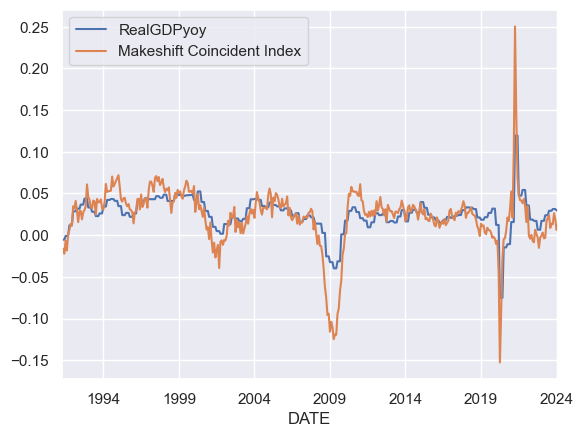

In [78]:
relationship = pd.concat([rgdp,own_yoy],axis=1).fillna(method = 'ffill').dropna()
relationship.plot()

In [79]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=relationship.index, y=relationship['RealGDPyoy'], name="Real GDP y/y"),
    secondary_y=False,)
fig.add_trace(
    go.Scatter(x=relationship.index, y=relationship['Makeshift Coincident Index'], name="Makeshift Coincident Index"),
    secondary_y=True,)
fig.update_layout(
    title_text="Real GDP y/y Realtionship with Makeshift Coincident Index",
    width=800,
    height=800)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="<b>Real GDP y/y</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Makeshift Coincident Index</b>", secondary_y=True)
fig.show()

In [80]:
fig = px.line(own_yoy['1990':].dropna().reset_index(), x="DATE", y=['Makeshift Coincident Index'],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Coincident Index')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title=" ")

THS Fundamentals

In [105]:
class Macro:
    
    """
    This class is mainly for my paper trading in spot markets. Derivatives will have a separate script. 
    """
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*35)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.symbols_list = 'THREEFF2','THREEFF10','DGS5', 'DGS10','DGS2','NASDAQCOM'
    
    def macro(self):
        symbols = []
        for ticker in self.symbols_list: 
            try:
                r = web.DataReader(ticker,'fred', self.fred_start, self.fred_end)
                r['ticker'] = ticker
                symbols.append(r)
            except:
                msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
        
            final = pd.concat(symbols)
            final_df = final.reset_index()
        
        return symbols, final_df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'close')
        return df[start:end]
    
class Trading:
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*35)).split()[0]
        self.fred_end = dt.datetime.now()

        self.interval = '1d'
        self.ticker_list = ["SPY",'WMT','THS','AMZN','COST','TGT','ACI','KR','^TNX'] ### Food and Beverage

    def yahoo_universe(self):
        web3 = []
        failed = []
        for security in self.ticker_list:
            try:                                                    
                interval = '1d' 
                query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{security}?period1={self.period1}&period2={self.period2}&interval={self.interval}&events=history&includeAdjustedClose=true'
                df = pd.read_csv(query_string).set_index("Date")
                df['ticker'] = security
                df.columns = ['Open', 'High', 'Low','Close','Adj Close','Volume','ticker']
                web3.append(df)
            except:
                failed.append(security)                                                
                pass
            final = pd.concat(web3)
            df_final = final.reset_index()
        return df_final, web3, failed

    
    def trading_sql(self, data_file):
        try:
            conn = sqlite3.connect('tradable_universe') 
            data_file.to_sql("consensusinvestable", conn, if_exists='replace', index = False)
            conn.commit()
            conn.close()
            print("Updating the sql table was a success")
        except:
            print("Was unsuccessful in uploading the dataframe into the datatable. ")
    
    
    def to_trading_sql(self, data):
        
        """
        Inputs: dataframe you want to upload
        Outputs: saves SQL table to the investable database 
        """
        
        try:
            connection = sqlite3.connect(config.db_file)
            data.to_sql("consensusinvestable", connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
            print("Uploading dataframe to database worked successfully.")
        except:
            print("Was unable to save the dataframe into the investable datatable.")

    
    def load_sql(self):
        try:
            conn = sqlite3.connect('tradable_universe') 
            df = pd.read_sql_query("SELECT * from consensusinvestable", conn)
            conn.commit()
            conn.close()
        except:
            print("Could not retrieve the datatable. ")
        return df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'Adj Close')
        return df[start:end]

In [106]:
import requests
def fundamentals(ticker, base_url, data_type, API_KEY):   
    url = f'{base_url}/v3/{data_type}/{ticker}?period=quarter&limit=400&apikey={API_KEY}'
    response = requests.get(url)
    data = response.json()
    return pd.DataFrame(data)

def fundamental_data(base_url, tickers, API_KEY):
    try:
        dataframe = []
        for ticker in tickers:
            data_type = ['income-statement','balance-sheet-statement','cash-flow-statement']
            inc = fundamentals(ticker, base_url, data_type[0], API_KEY)
            inc = inc.set_index('date')
            bs = fundamentals(ticker, base_url, data_type[1], API_KEY)
            bs = bs.set_index('date')
            bs = bs.add_suffix('_bs')
            cf = fundamentals(ticker, base_url, data_type[2], API_KEY)
            cf = cf.set_index('date')
            cf = cf.add_suffix('_cf')
            df = pd.concat([inc, bs, cf],axis=1)
            df['workingCapital'] = (df['totalCurrentAssets_bs'] - df['totalCurrentLiabilities_bs'])     # higher the better for liquidity but should be checked with sales to AR (need this going up)
            df['quickRatio'] = (df['totalCurrentAssets_bs'] - df['inventory_bs']) / df['totalCurrentLiabilities_bs']  # kicks out inventory
            df['ROCE'] = ((df['ebitda'] - df['depreciationAndAmortization']) / (df['totalAssets_bs'] - df['totalCurrentLiabilities_bs']))*100
            df['ROTC'] = ((df['ebitda'] - df['depreciationAndAmortization']) / (df['longTermDebt_bs'] + df['shortTermDebt_bs'] + df['capitalLeaseObligations_bs'] + df['totalEquity_bs']))
            df['fcf'] = df['operatingCashFlow_cf'] - df['dividendsPaid_cf'] + df['changeInWorkingCapital_cf'] + df['capitalExpenditure_cf']  
            df['DSO'] = (df['netReceivables_bs'] / df['costOfRevenue']) * 365   # trending lower could signal ads to quickly collect cash from vendors (inflating CFFO)
            df['DPO'] = (df['accountPayables_bs'] / df['costOfRevenue']) * 365  # trending Higher means they are stretching out how fast they pay vendors inflation CFFO
            df['InventoryTurnover'] = df['costOfRevenue'] / df['inventory_bs']  # higher the better so there's no inventory buildup 
            df['AssetQuality'] = (df['totalNonCurrentAssets_bs'] - df['propertyPlantEquipmentNet_bs']) / df['totalAssets_bs']
            df['CFFOtoCAPEX'] = df['operatingCashFlow_cf'] / (df['capitalExpenditure_cf']*-1)  # should be pretty stable but declining trend could mean accumulation of debt signal
            df['FixedChargeCoverage'] = df['ebitda'] / df['interestExpense']                   # can there earnings cover interest charges relative to comps
            df['netLongTermDebtLev'] = (df['longTermDebt_bs'] - df['cashAndCashEquivalents_bs']) / df['ebitda']  # net debt to ebitda is a good leverage indicator
            df['workingCapRatio'] = (df['totalCurrentAssets_bs'] - df['totalCurrentLiabilities_bs']) / df['totalAssets_bs']  # higher working capital relative to asset size
            df['reinvestToAssets'] = df['retainedEarnings_bs'] / df['totalAssets_bs']          # reinvest is assets accumulation is good for a company as extra earnings 
            df['ROC'] = (df['ebitda'] - df['depreciationAndAmortization']) / df['totalAssets_bs']   # are they using their assets efficiently
            df['leverage'] = df['totalEquity_bs'] / df['totalLiabilities_bs']                  # equity cushion - can their book value of equity cover their liabilities 
            df['assetTurnover'] = df['revenue'] / df['totalAssets_bs']                         # are their assets efficiently driving the top-line
            df['Altman Z-Score'] = 1.2 * df['workingCapRatio'] + 1.4 * df['reinvestToAssets'] + 3.3 * df['ROC'] + 0.6 * df['leverage'] + 1.0 * df['assetTurnover']
            df = df.reset_index().set_index('fillingDate')
            # df.index = pd.to_datetime(df.index)
            dataframe.append(df)
    except:
        pass
    return pd.concat(dataframe), bs, inc, cf

def earnings_surprise_function(tickers, API_KEY, sector):    
    try:
        er = []
        for ticker in tickers:
            surprise = f'https://financialmodelingprep.com/api/v3/earnings-surprises/{ticker}?apikey={API_KEY}'
            response = requests.get(surprise)
            ear_sur = response.json()
            earnings_surprise = pd.DataFrame(ear_sur)
            earnings_surprise['surprise'] = earnings_surprise['actualEarningResult'] - earnings_surprise['estimatedEarning']
            er.append(earnings_surprise)
        eps_surp = pd.concat(er).set_index('date')
        eps_surp.index = pd.to_datetime(eps_surp.index)
        eps_surp = eps_surp.sort_index()
        mean_er = eps_surp.groupby(pd.Grouper(freq='Q'))[['surprise']].mean()
        mean_er.columns = ['Mean Surprise']
        med_er = eps_surp.groupby(pd.Grouper(freq='Q'))[['surprise']].median()
        med_er.columns = ['Median Surprise']
        earn_surp = pd.concat([mean_er, med_er],axis=1)
        earn_surp.plot(title=f'{sector} Earnings Surprise')
    except:
         pass
    return eps_surp

In [107]:
base_url = 'https://financialmodelingprep.com/api'
ths = ['THS','TGT','AMZN','WMT','ACI','KR']
main = Trading(0, "2018-01-01", "2020-01-01")         # set first input to one if you want exact date inputs
df, df1, df2 = main.yahoo_universe()                  # dont have to run this everytime
main.trading_sql(df)  

Updating the sql table was a success


In [109]:
pd.set_option('display.max_columns',None)   # dislay all columns so we can see better
df1 = df.pivot_table(columns = 'ticker',values = 'Adj Close',index = 'Date').drop(['^TNX','SPY'],axis=1)           # drop benchmark and risk free rate
df1.index = pd.to_datetime(df1.index, format='%Y-%m-%d')
df1 = df1.drop(['ACI'], axis=1).dropna()

In [110]:
df_fund = fundamental_data(base_url, df1.columns, API_KEY)

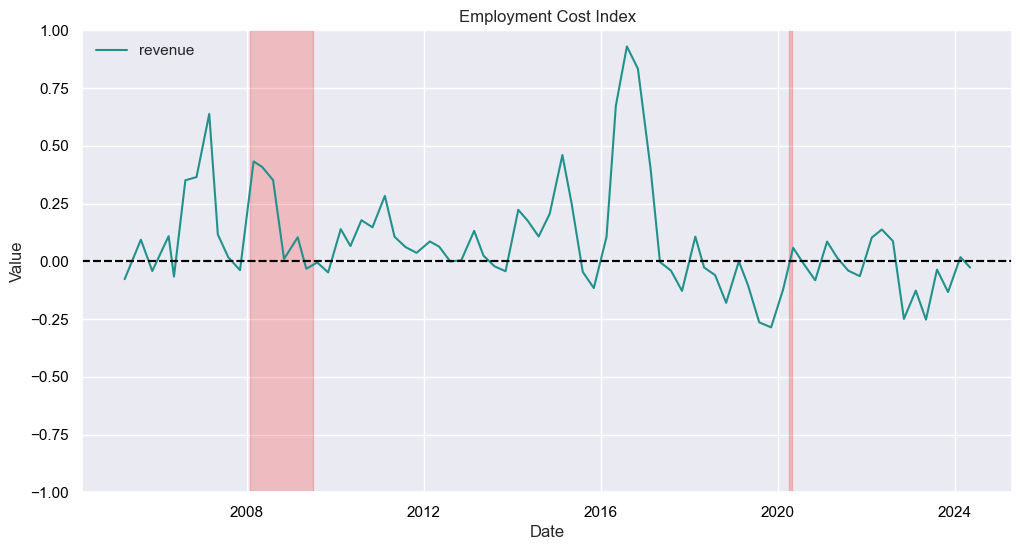

In [316]:
rev_ths = df_fund[0][df_fund[0]['symbol'] == 'THS'].sort_index()[['revenue']]
rev_ths.index = pd.to_datetime(rev_ths.index)
rev_ths = (rev_ths / rev_ths.shift(3)) - 1
start='2005-01-01'
eco_plot(rev_ths, start, end, 'Employment Cost Index', -1, 1,0,0,plot=True, save_fig=False)

In [207]:
def sector_metron_dtd(df_fund, df, ticker, maturity, recovery, override):    
    try:
        sector_data = []
        comp = df_fund[0][df_fund[0]['symbol'] == ticker].sort_index()
        comp.index = pd.to_datetime(comp.index)
        df = df[[ticker]].dropna()
        comp_comb = pd.concat([comp[['shortTermDebt_bs','longTermDebt_bs','totalEquity_bs','weightedAverageShsOutDil','DSO','DPO',
                                    'netLongTermDebtLev','FixedChargeCoverage','workingCapRatio','reinvestToAssets',
                                    'ROC','ROTC','leverage','AssetQuality','ROCE','freeCashFlow_cf','revenue','ebitda']],df],axis=1).fillna(method='ffill').dropna()
        comp_comb['mkt_cap'] = comp_comb[ticker] * comp_comb['weightedAverageShsOutDil']
        comp_comb[f'{ticker}_debt_to_ebitda'] = (comp_comb['shortTermDebt_bs'] + comp_comb['longTermDebt_bs']) / (comp_comb['ebitda']+comp_comb['ebitda'].shift(1)+comp_comb['ebitda'].shift(2)+comp_comb['ebitda'].shift(3))
        comp_comb[f'{ticker}_fcf_yield'] = comp_comb['freeCashFlow_cf'] / comp_comb['mkt_cap']
        comp_comb[f'{ticker}_revenue_yield'] = comp_comb['revenue'] / comp_comb['mkt_cap']
        comp_comb[f'{ticker}_Revenue'] = comp_comb['revenue']
        comp_comb[f'{ticker}_ROC'] = comp_comb['ROC']
        comp_comb[f'{ticker}_ROTC'] = comp_comb['ROTC']
        comp_comb[f'{ticker}_ROCE'] = comp_comb['ROCE']
        comp_comb['dpt'] = comp_comb['shortTermDebt_bs'] + .5*comp_comb['longTermDebt_bs']
        if override == False:
            comp_comb['mu'] = (comp_comb['mkt_cap'].shift(1) / comp_comb['mkt_cap'].shift(252))-1
        else:
            comp_comb['mu'] = 0.06                                                           # override feature if last year returns were an outlier
        comp_comb['sigma'] = comp_comb['mkt_cap'].pct_change().rolling(1000).std()*(252**0.5)
        comp_comb['numerator'] = np.log(comp_comb['mkt_cap'] / comp_comb['dpt']) + (comp_comb['mu'] - (comp_comb['sigma'].pow(2)) / 2.0) * maturity
        comp_comb['denominator'] = comp_comb['sigma'] * maturity
        comp_comb[f'{ticker}_dtd'] = comp_comb['numerator'] / comp_comb['denominator']
        comp_comb[f'{ticker}_edf'] = norm.cdf(-comp_comb[f'{ticker}_dtd'])                   # added a 1
        comp_comb[f'{ticker}_Spread'] = ((comp_comb[f'{ticker}_edf']*recovery) / 1-recovery) # spread is just the EDF * Recovery Rate (0.4) / 1-Recovery Rate (0.6)
        comp_comb[f'{ticker}_CDS_Spread'] = (np.log(1-comp_comb[f'{ticker}_edf']) * ((recovery - 1) / maturity))*100
        comp_comb[f'{ticker}_Credit_Spread'] = (-1*.6)*(np.log(norm.cdf(comp_comb[f'{ticker}_dtd']))/maturity)*10000
        sector_data.append(comp_comb[[ticker,f'{ticker}_dtd']])
        return comp_comb[[ticker,f'{ticker}_CDS_Spread',f'{ticker}_Credit_Spread',f'{ticker}_dtd',f'{ticker}_ROC',f'{ticker}_ROCE',
                          f'{ticker}_fcf_yield',f'{ticker}_revenue_yield',f'{ticker}_ROTC','dpt',f'{ticker}_Revenue',f'{ticker}_debt_to_ebitda']]
    except:
        print(ticker)

def sector_CreditGrades(df_fund, df, ticker, maturity, recovery, vol_recovery):    
    try:
        sector_data = []
        comp = df_fund[0][df_fund[0]['symbol'] == ticker].sort_index()
        comp.index = pd.to_datetime(comp.index)
        df = df[[ticker]].dropna()
        comp_comb = pd.concat([comp[['taxPayables_bs','deferredRevenue_bs','otherCurrentLiabilities_bs','shortTermDebt_bs',
                                        'longTermDebt_bs','deferredRevenueNonCurrent_bs','deferredTaxLiabilitiesNonCurrent_bs',
                                        'otherNonCurrentLiabilities_bs','capitalLeaseObligations_bs',
                                        'minorityInterest_bs','weightedAverageShsOutDil']],df],axis=1).fillna(method='ffill').dropna()
        comp_comb['mkt_cap'] = comp_comb[ticker] * comp_comb['weightedAverageShsOutDil']
        # comp_comb['hist_avg'] = comp_comb[ticker].rolling(1000).mean()
        comp_comb['hist_avg'] = comp_comb[ticker]
        comp_comb['log_returns'] = np.log(comp_comb[ticker] / comp_comb[ticker].shift(1)).dropna()
        comp_comb['otherSTLiabs'] = (comp_comb['taxPayables_bs'] + comp_comb['deferredRevenue_bs'] + comp_comb['otherCurrentLiabilities_bs'])
        comp_comb['otherLTLiabs'] = (comp_comb['deferredRevenueNonCurrent_bs'] + comp_comb['deferredTaxLiabilitiesNonCurrent_bs'] + comp_comb['otherNonCurrentLiabilities_bs'] + comp_comb['capitalLeaseObligations_bs'])
        comp_comb['Debt'] = (comp_comb['shortTermDebt_bs'] + comp_comb['longTermDebt_bs'])+0.5*(comp_comb['otherSTLiabs']+comp_comb['otherLTLiabs']) + comp_comb['minorityInterest_bs']
        comp_comb['Debt / Share'] = comp_comb['Debt'] / comp_comb['weightedAverageShsOutDil']
        comp_comb['recovery_mu'] = recovery
        comp_comb['vol_recovery'] = vol_recovery
        comp_comb['T'] = maturity
        comp_comb['risk_free'] = 0.03
        ### asset value volatility is just the equity value standardized to equity per share and recoverable debt ###
        comp_comb['sigma'] = (comp_comb['log_returns'].dropna().rolling(1000).std() * np.sqrt(252))
        # comp_comb['sigma'] = (comp_comb['log_returns'].dropna().rolling(1000).std() * np.sqrt(252)) * (comp_comb['hist_avg'] / (comp_comb['hist_avg'] + comp_comb['recovery_mu'] * comp_comb['Debt / Share']))

        ### asset value ###
        comp_comb['V0'] = comp_comb[ticker] + comp_comb['recovery_mu'] * comp_comb['Debt / Share'] 

        ### distance to default - how far (standard deviation) assets are from default point ###
        comp_comb['d'] = comp_comb['V0'] * np.exp(comp_comb['vol_recovery']**2) / comp_comb['recovery_mu'] / comp_comb['Debt / Share']
        # comp_comb['d'] = (comp_comb['V0'] * np.exp(comp_comb['vol_recovery']**2)) / (comp_comb['recovery_mu'] * comp_comb['Debt / Share'])

        ### At and At0 are volatility terms adjusted for time ### 
        comp_comb['At'] = np.sqrt((comp_comb['sigma'] * comp_comb['hist_avg'] / (comp_comb['hist_avg'] + comp_comb['recovery_mu'] * comp_comb['Debt / Share'])) ** 2 * comp_comb['T'] + comp_comb['vol_recovery'] ** 2)
        comp_comb['At0'] = np.sqrt((comp_comb['sigma'] * comp_comb['hist_avg'] / (comp_comb['hist_avg'] + comp_comb['recovery_mu'] * comp_comb['Debt / Share'])) ** 2 * 0 + comp_comb['vol_recovery'] ** 2)

        ### probability of survival is just 
        comp_comb['ps'] = norm.cdf(-comp_comb['At']/2+np.log(comp_comb['d']) / comp_comb['At']) - comp_comb['d'] * norm.cdf(-comp_comb['At']/2-np.log(comp_comb['d'])/comp_comb['At'])
        comp_comb['ps0'] = norm.cdf(-comp_comb['At0']/2+np.log(comp_comb['d']) / comp_comb['At0']) - comp_comb['d'] * norm.cdf(-comp_comb['At0']/2-np.log(comp_comb['d'])/comp_comb['At0'])
        
        comp_comb['std'] = comp_comb['sigma'] * comp_comb['hist_avg'] / (comp_comb['hist_avg'] + comp_comb['recovery_mu'] * comp_comb['Debt / Share'])
        comp_comb['z'] = np.sqrt(0.25 + 2 * comp_comb['risk_free'] / comp_comb['std']) ** 2

        comp_comb['eps'] = (comp_comb['vol_recovery'] / comp_comb['std']) ** 2
        comp_comb['eps + T'] = comp_comb['T'] + ((comp_comb['vol_recovery'] / comp_comb['std']) ** 2)

        comp_comb['a'] = -np.log(comp_comb['d']) / comp_comb['std'] / np.sqrt(comp_comb['eps']) - comp_comb['z'] * comp_comb['std'] * np.sqrt(comp_comb['eps'])
        comp_comb['b'] = -np.log(comp_comb['d']) / comp_comb['std'] / np.sqrt(comp_comb['eps']) + comp_comb['z'] * comp_comb['std'] * np.sqrt(comp_comb['eps'])

        comp_comb['at'] = -np.log(comp_comb['d']) / comp_comb['std'] / np.sqrt(comp_comb['eps + T']) - comp_comb['z'] * comp_comb['std'] * np.sqrt(comp_comb['eps + T'])
        comp_comb['bt'] = -np.log(comp_comb['d']) / comp_comb['std'] / np.sqrt(comp_comb['eps + T']) + comp_comb['z'] * comp_comb['std'] * np.sqrt(comp_comb['eps + T'])

        comp_comb['g'] = comp_comb['d'] ** (comp_comb['z'] + 0.5) * norm.cdf(comp_comb['a']) + comp_comb['d'] ** (-comp_comb['z'] + 0.5) * norm.cdf(comp_comb['b'])
        comp_comb['gt'] = comp_comb['d'] ** (comp_comb['z'] + 0.5) * norm.cdf(comp_comb['at']) + comp_comb['d'] ** (-comp_comb['z'] + 0.5) * norm.cdf(comp_comb['bt'])

        comp_comb['Num'] = 1 - comp_comb['ps0'] + np.exp(comp_comb['risk_free'] * comp_comb['eps']) * (comp_comb['gt'] - comp_comb['g'])
        comp_comb['Dn'] = comp_comb['ps0'] - comp_comb['ps'] * np.exp(-comp_comb['risk_free'] * comp_comb['T']) - np.exp(comp_comb['risk_free'] * comp_comb['eps']) * (comp_comb['gt'] - comp_comb['g'])
        comp_comb['res'] = 10000 * comp_comb['risk_free'] * (1 - comp_comb['recovery_mu']) * comp_comb['Num'] / comp_comb['Dn']
        comp_comb['res1'] = (comp_comb['res'] - 0 / 10000) * comp_comb['Dn'] / comp_comb['risk_free']
        comp_comb[f'{ticker} CDS Implied Spread'] = comp_comb[['res','res1']].min(axis=1)
        # sector_data.append(comp_comb[[ticker,f'{ticker}_dtd']])
        return comp_comb[[ticker, f'{ticker} CDS Implied Spread']]
    except:
        pass

<Axes: xlabel='DATE'>

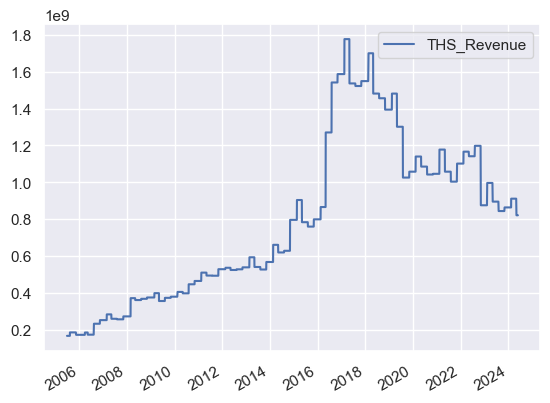

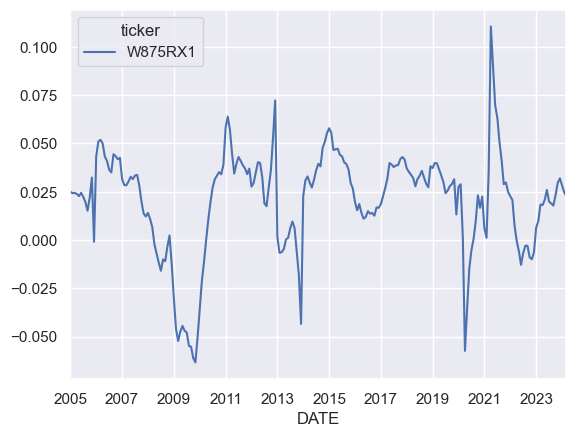

In [271]:
sector_metron_dtd(df_fund, df1, 'THS', 5, 0.5, True)[['THS_Revenue']].plot()

<Axes: xlabel='DATE'>

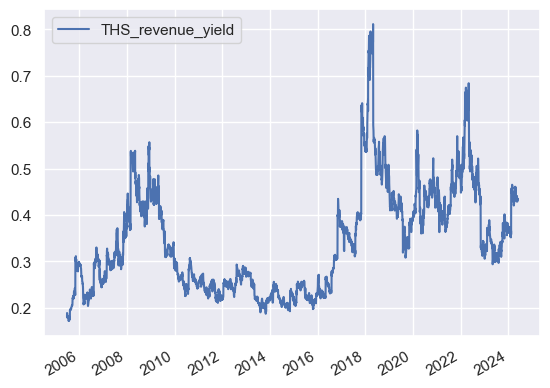

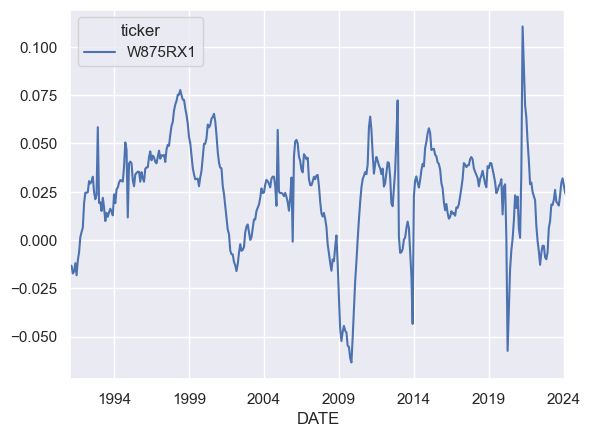

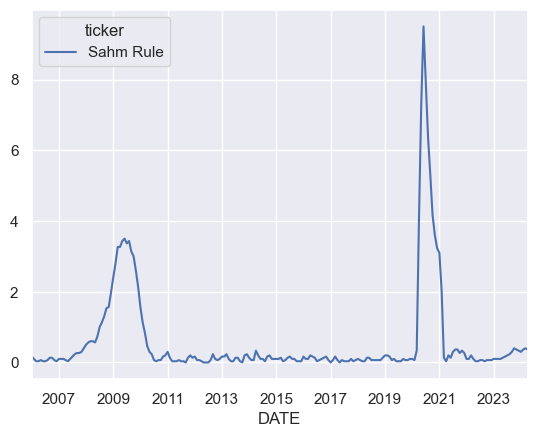

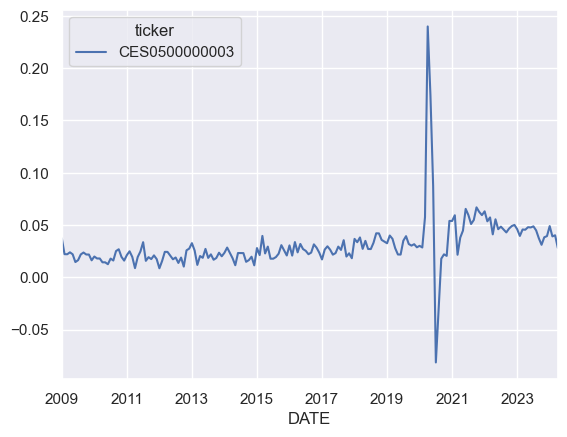

In [266]:
sector_metron_dtd(df_fund, df1, 'THS', 5, 0.5, False)[['THS_revenue_yield']].plot()
tickers = ['W875RX1']
start = '1990-01-02'
end = dt.datetime.now()
pi_less = initial.dataframe(tickers, data.set_index("DATE"), start, end)
pi_less = ((pi_less/pi_less.shift(12))-1).dropna()
pi_less.plot()
unemployment[['Sahm Rule']]['2006':].plot()
he3mo['2009':].plot()


<Axes: >

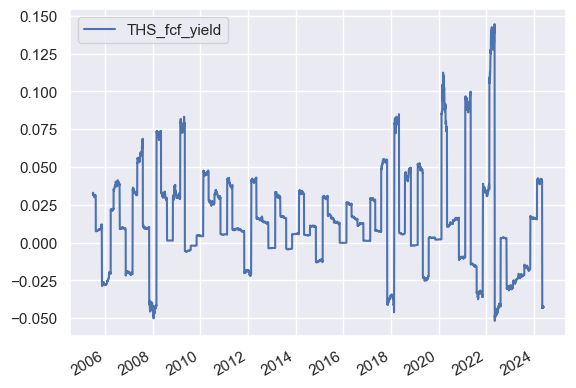

In [209]:
sector_metron_dtd(df_fund, df1, 'THS', 5, 0.5, False)[['THS_fcf_yield']].plot()

<Axes: xlabel='DATE'>

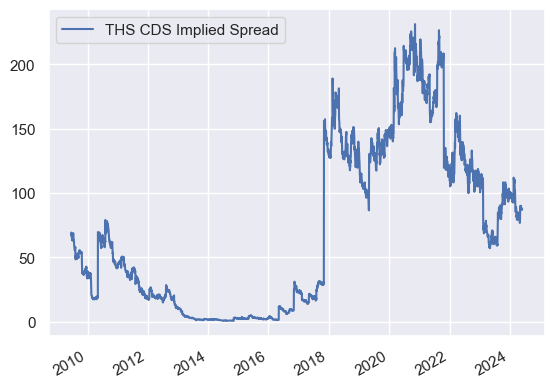

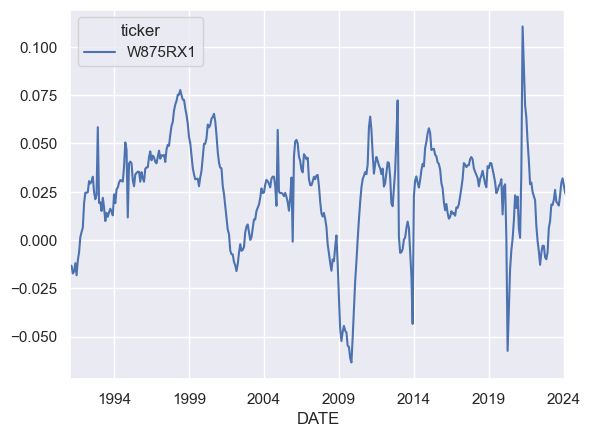

In [267]:
sector_CreditGrades(df_fund, df1, 'THS', 5, .5, .3).dropna()[['THS CDS Implied Spread']].plot()
pi_less.plot()

<Axes: xlabel='DATE'>

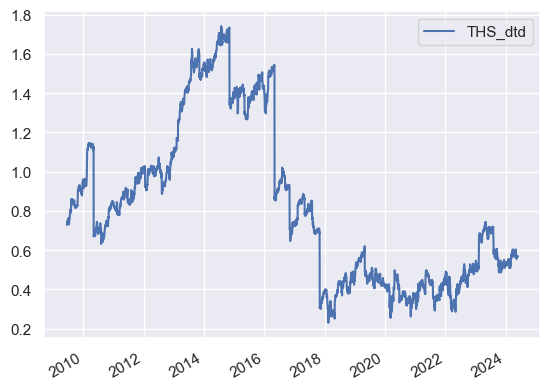

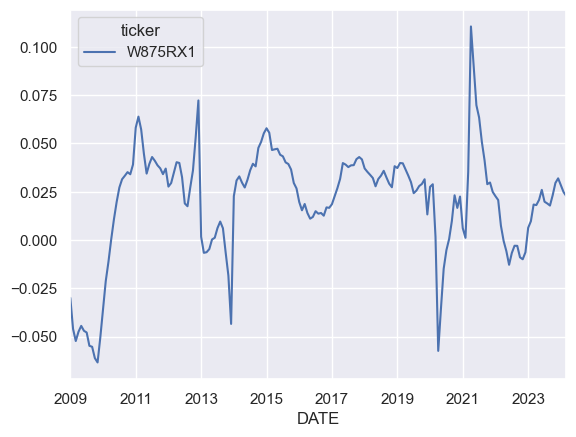

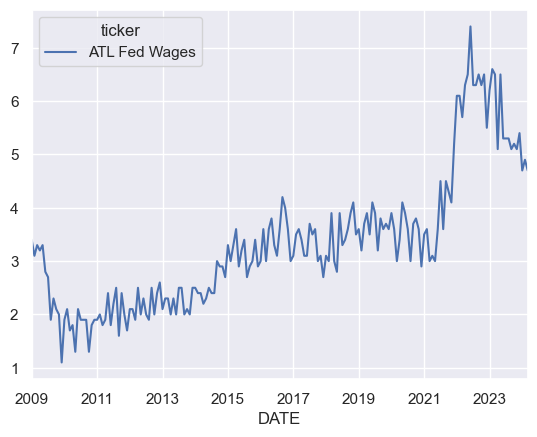

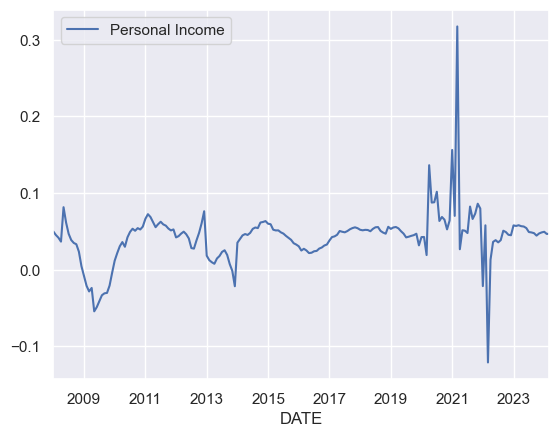

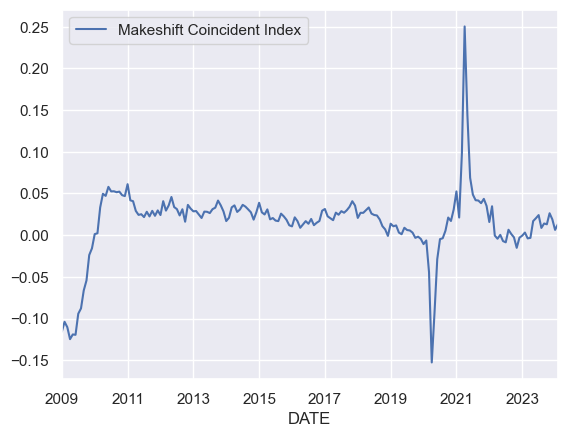

In [268]:
sector_metron_dtd(df_fund, df1, 'THS', 5, 0.5, True)[[f'THS_dtd']].plot()
pi_less['2009':].plot()
savings_to_wages['2009':][['ATL Fed Wages']].plot()
pi_yoy['2008':].plot()
relationship['2009':][['Makeshift Coincident Index']].plot()

In [161]:
data.pivot_table(columns = 'ticker', values = 'close', index = 'DATE').columns
# [['FRBATLWGTUMHWG83O']].dropna().plot()
# QBPBSTAS = Balance Sheet Total Assets
# WSHOFADSL = Assets: Securities Held Outright
# FRBATLWGTUMHWG83O = unweighted median hourly wage growth


Index(['AAA', 'AMTMNO', 'AWHMAN', 'BAMLC0A1CAAAEY', 'BAMLC0A4CBBBEY',
       'BAMLH0A0HYM2', 'BAMLH0A3HYC', 'CDSP', 'CES0500000003', 'CFNAI',
       'CFNAIMA3', 'CMRMTSPL', 'COMREPUSQ159N', 'CPIAUCSL', 'CPILFESL', 'DBAA',
       'DGS10', 'DGS2', 'DGS30', 'DPCCRV1Q225SBEA', 'DRTSCILM', 'DRTSCIS',
       'DSPI', 'ECIALLCIV', 'EFFR', 'FEDFUNDS', 'FRBATLWGTUMHWG83O',
       'FRBKCLMCILA', 'FYFSGDA188S', 'GCEC1', 'GDPC1', 'GDPNOW', 'ICSA',
       'INDPRO', 'IPMAN', 'JTSHIR', 'JTSJOL', 'LNS11324230', 'LNS12300060',
       'M1V', 'M2V', 'MABMM301USA189S', 'NEWORDER', 'PALLFNFINDEXQ', 'PAYEMS',
       'PCE', 'PCEC96', 'PCETRIM12M159SFRBDAL', 'PERMIT', 'PI', 'PMSAVE',
       'PSAVERT', 'QBPBSTAS', 'QUSR368BIS', 'T10Y3M', 'T5YIFR', 'TCU', 'TDSP',
       'TEMPHELPS', 'TREAS15', 'TREAS1T5', 'TREAS5T10', 'TREAST', 'UMCSENT',
       'UNRATE', 'USALOLITONOSTSAM', 'USREC', 'W398RC1A027NBEA', 'W875RX1',
       'WALCL', 'WCURCIR', 'WDTGAL', 'WEI', 'WLCFLL', 'WLRRAL', 'WM2NS',
       'WORAL', 'WSHOFADSL'

In [244]:
savings_to_wages['2010':].columns

Index(['ATL Fed Wages', 'Personal Savings', 'Personal Savings divided by 100'], dtype='object', name='ticker')

<Axes: xlabel='DATE'>

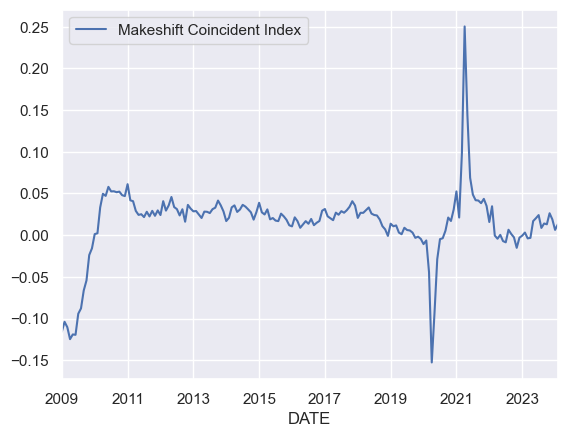

In [143]:
relationship['2009':][['Makeshift Coincident Index']].plot()

In [282]:
fig = px.scatter(relationship, y = 'RealGDPyoy', x='Makeshift Coincident Index', width=700, height=500, 
                 trendline='ols', trendline_color_override='DeepPink', 
                 marginal_x='histogram', marginal_y='histogram', title=f'Joint Distribution')
fig.show()

In [283]:
new_relationship = pd.concat([rgdp,own_yoy],axis=1)
new_relationship['coincident_lag'] = new_relationship['Makeshift Coincident Index'].shift(1)
new_relationship['coincident_lag2'] = new_relationship['Makeshift Coincident Index'].shift(2)
new_relationship['coincident_lag3'] = new_relationship['Makeshift Coincident Index'].shift(3)
# df_hope = new_relationship[['Real GDP y/y','Makeshift Coincident Index']].dropna()
df_hope = new_relationship[['RealGDPyoy','coincident_lag']].dropna()
# df_hope = new_relationship[['Real GDP y/y','coincident_lag2']].dropna()
# df_hope = new_relationship[['Real GDP y/y','coincident_lag3']].dropna()

df_hope = new_relationship[['RealGDPyoy','coincident_lag']].dropna()
fig = px.scatter(df_hope, y = 'RealGDPyoy', x='coincident_lag', width=700, height=500, 
                 trendline='ols', trendline_color_override='DeepPink', 
                 marginal_x='histogram', marginal_y='histogram', title=f'Joint Distribution')
fig.show()

Assumptions of Linear Regression

                            OLS Regression Results                            
Dep. Variable:             RealGDPyoy   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     280.7
Date:                Fri, 03 May 2024   Prob (F-statistic):           2.84e-34
Time:                        13:29:37   Log-Likelihood:                 402.60
No. Observations:                 132   AIC:                            -801.2
Df Residuals:                     130   BIC:                            -795.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0137      0.001     11.

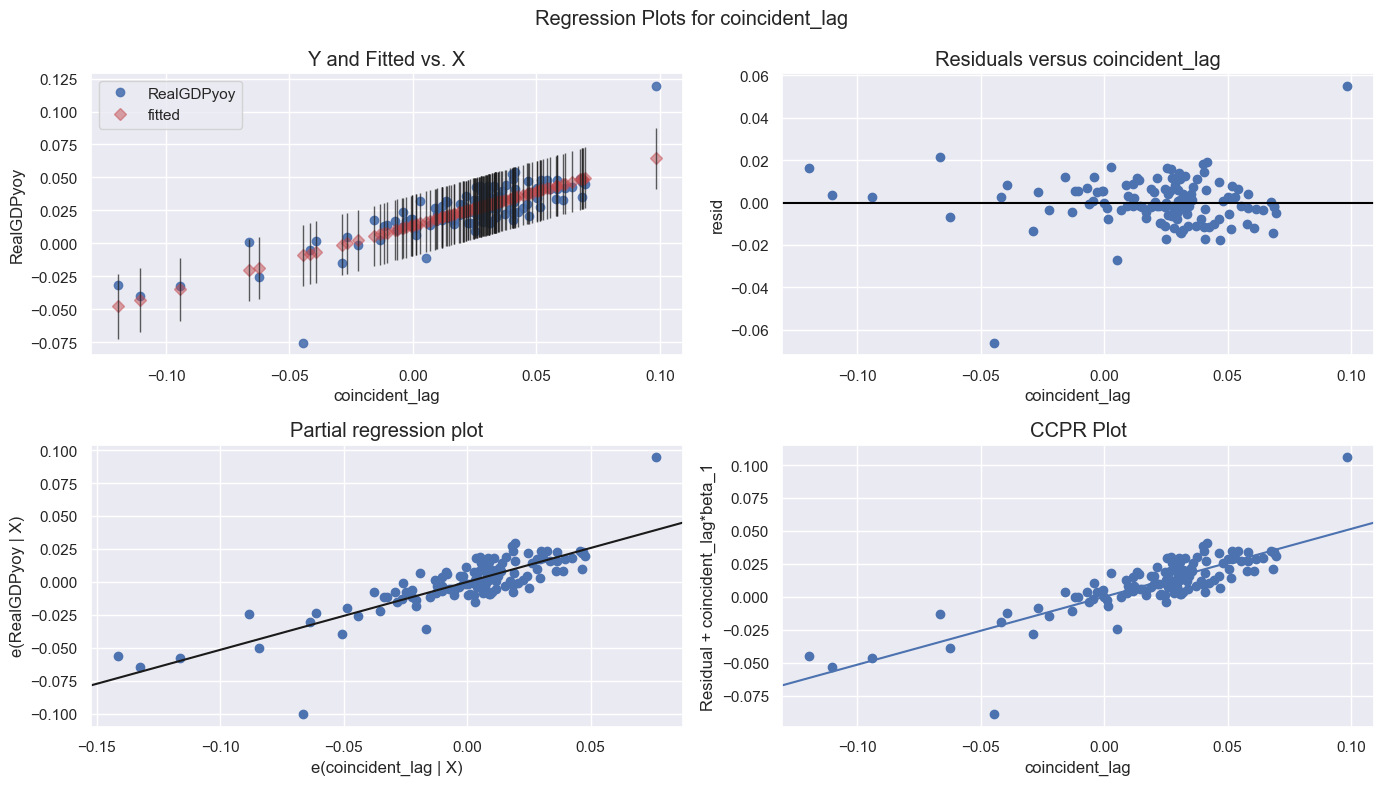

In [284]:
import pandas as pd 
import matplotlib.pyplot as plt 
import statsmodels.api as sm 
from statsmodels.formula.api import ols 

linear_model = ols('RealGDPyoy~coincident_lag', data=df_hope).fit()
print(linear_model.summary()) 
fig = plt.figure(figsize=(14, 8)) 
fig = sm.graphics.plot_regress_exog(linear_model, 
                                    'coincident_lag', 
                                    fig=fig)

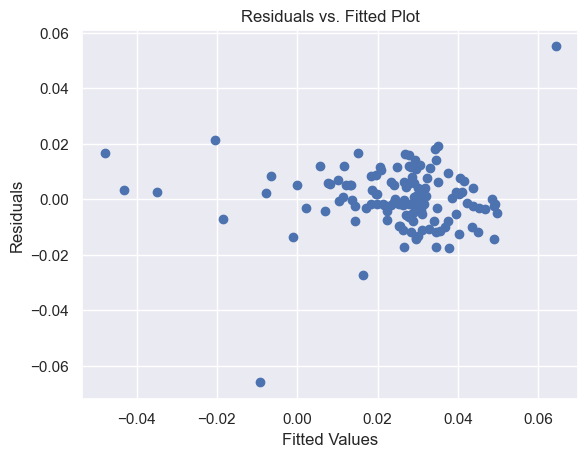

In [287]:
fitted = linear_model.fittedvalues
residuals = linear_model.resid
plt.scatter(fitted, residuals)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Plot")
plt.show()

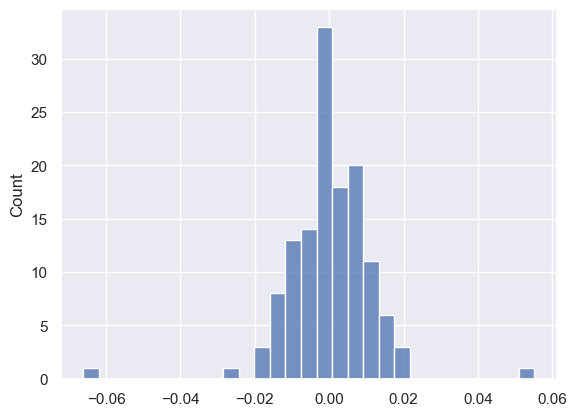

In [288]:
import seaborn as sns
sns.histplot(linear_model.resid);

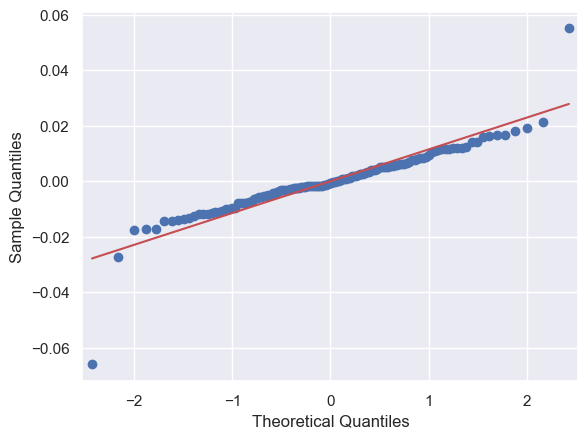

In [289]:
sm.qqplot(linear_model.resid, line='s');

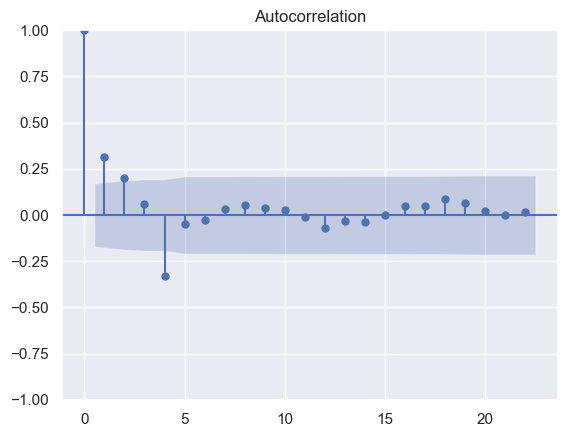

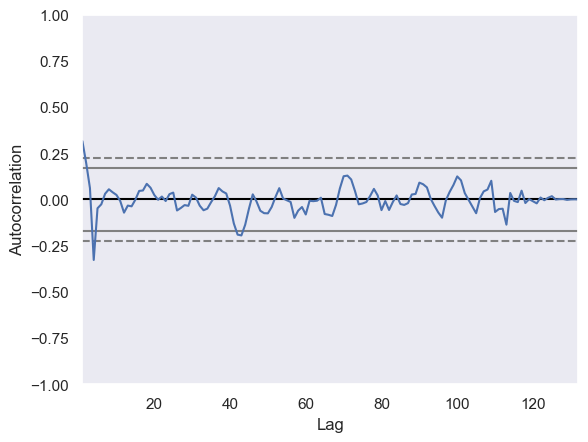

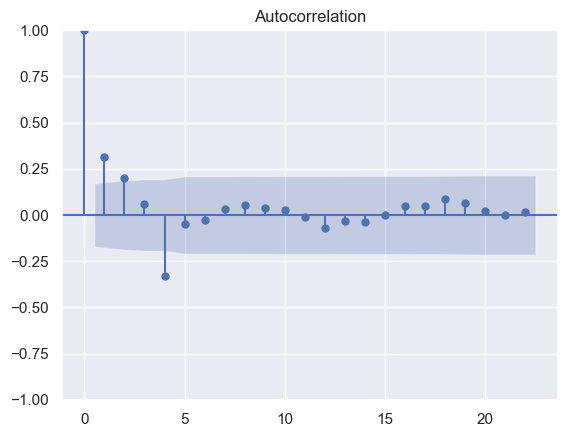

In [290]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

autocorrelation_plot(linear_model.resid)
plot_acf(linear_model.resid)

Equal Weighted Index vs SP500

In [293]:
main = Trading(0, "2018-01-01", "2020-01-01")   # set first input to one if you want exact date inputs
df, df1, df2 = main.yahoo_universe()            # dont have to run this everytime
main.trading_sql(df)   

Updating the sql table was a success


In [294]:
final = main.load_sql().set_index("Date")
tickers =["SPY","RSP","XLV","VNQ","XLP","XLU","MUB","SPLV","DEF","XLRE","IEF",
    "GDXJ","MBB", "UUP","IWM","XLP","HG=F","GC=F",'XLY','^DJT','^SP500-55',
    '^SP500-30','^SP500-25','XLK','^RUT','TLT','GLD','QQQ','GDX','GDXJ','XOP','KRE',
    'XBI','XLF','XLE','XRT','XLI','XHB','XLP','JNK','DIA','XME','SRLN','XLB',
    'MDY','KBE','SJNK','CWB','SDY','FEZ','XAR','GNR','KIE','XES','XSW','XSD','GXC','SPEM',
    'SPDW','XTN','SPMB','SLYV','MDYV']
start = '2000-01-01'
end = '2024-01-12'
dfcap = main.dataframe(tickers, final, start, end)
dfcap = dfcap.dropna()
dfcap['DiscretionaryToStaples'] = dfcap["^SP500-25"] / dfcap["^SP500-30"]
dfcap['TransportsToUtilities'] = (dfcap["^DJT"] / dfcap["^SP500-55"])/100
dfcap['CopperToGold'] = (dfcap["HG=F"] / dfcap["GC=F"])*100
dfcap.index = pd.to_datetime(dfcap.index)
daily = dfcap.copy()
daily

ticker            CWB        DEF         DIA        FEZ         GC=F  \
Date                                                                   
2015-10-08  33.069672  34.654308  142.425491  28.332056  1144.699951   
2015-10-09  33.098503  34.580929  142.751587  28.489883  1156.300049   
2015-10-12  33.076870  34.626141  143.094238  28.418869  1164.900024   
2015-10-13  32.896935  34.344025  142.651154  28.134756  1165.800049   
2015-10-14  33.012104  34.322552  141.338760  28.253136  1180.099976   
...               ...        ...         ...        ...          ...   
2024-01-08  70.793053  71.843201  374.936127  47.120323  2026.599976   
2024-01-09  70.733376  71.708199  373.284576  46.601311  2026.400024   
2024-01-10  70.972046  71.984497  375.045624  46.860821  2021.699951   
2024-01-11  70.942207  71.978302  375.264526  46.800934  2014.300049   
2024-01-12  70.862656  72.260002  374.010864  46.860821  2046.699951   

ticker            GDX       GDXJ         GLD        GNR        GXC  ...  \
Date                                                                ...   
2015-10-08  14.120078  18.683385  109.139999  27.728556  62.732292  ...   
2015-10-09  14.898927  19.601070  110.870003  27.992281  62.590454  ...   
2015-10-12  14.459106  19.405063  111.309998  27.668282  62.932556  ...   
2015-10-13  14.541574  19.244689  111.860001  27.208649  62.239971  ...   
2015-10-14  15.485352  20.688039  113.809998  27.547718  62.206589  ...   
...               ...        ...         ...        ...        ...  ...   
2024-01-08  29.700001  35.889999  187.869995  55.959999  64.930000  ...   
2024-01-09  29.170000  35.360001  187.929993  54.959999  64.220001  ...   
2024-01-10  29.110001  35.480000  187.500000  54.590000  64.070000  ...   
2024-01-11  28.889999  35.139999  187.869995  54.480000  64.730003  ...   
2024-01-12  29.700001  36.360001  189.710007  54.689999  64.500000  ...   

ticker             XSW        XTN          ^DJT         ^RUT    ^SP500-25  \
Date                                                                        
2015-10-08   48.068184  42.713985   8191.629883  1163.239990   615.750000   
2015-10-09   48.358978  43.670967   8253.160156  1165.359985   616.789978   
2015-10-12   48.320194  43.781380   8260.929688  1164.400024   619.710022   
2015-10-13   47.893707  42.612770   8077.740234  1147.839966   616.309998   
2015-10-14   47.409042  42.704781   8091.950195  1136.969971   610.030029   
...                ...        ...           ...          ...          ...   
2024-01-08  145.839996  81.931427  15645.959961  1989.010010  1393.359985   
2024-01-09  145.250000  80.834221  15512.299805  1968.040039  1391.469971   
2024-01-10  147.139999  80.894066  15602.870117  1970.260010  1405.160034   
2024-01-11  146.729996  80.525009  15534.900391  1955.459961  1404.750000   
2024-01-12  146.889999  79.357979  15470.530273  1950.959961  1390.050049   

ticker       ^SP500-30   ^SP500-55  DiscretionaryToStaples  \
Date                                                         
2015-10-08  506.739990  223.399994                1.215120   
2015-10-09  508.100006  222.490005                1.213915   
2015-10-12  509.290009  224.500000                1.216812   
2015-10-13  506.000000  223.919998                1.218004   
2015-10-14  500.269989  223.910004                1.219402   
...                ...         ...                     ...   
2024-01-08  767.989990  330.209991                1.814294   
2024-01-09  769.840027  327.709991                1.807479   
2024-01-10  768.869995  327.500000                1.827565   
2024-01-11  768.719971  319.820007                1.827388   
2024-01-12  771.380005  321.700012                1.802030   

ticker      TransportsToUtilities  CopperToGold  
Date                                             
2015-10-08               0.366680      0.205032  
2015-10-09               0.370945      0.209029  
2015-10-12               0.367970      0.207700  
2015-10-13               0.3

In [295]:
final = main.load_sql().set_index("Date")
tickers =["SPY"]
start = '2000-01-01'
end = '2024-01-12'
dfcap = main.dataframe(tickers, final, start, end)
dfcap = dfcap.dropna()
dfcap.index = pd.to_datetime(dfcap.index)
daily = dfcap.copy()
daily

ticker             SPY
Date                  
2000-01-03   93.591141
2000-01-04   89.931160
2000-01-05   90.092056
2000-01-06   88.644089
2000-01-07   93.792244
...                ...
2024-01-08  473.129974
2024-01-09  472.412201
2024-01-10  475.083893
2024-01-11  474.874542
2024-01-12  475.203522

[6046 rows x 1 columns]

<Axes: xlabel='Date'>

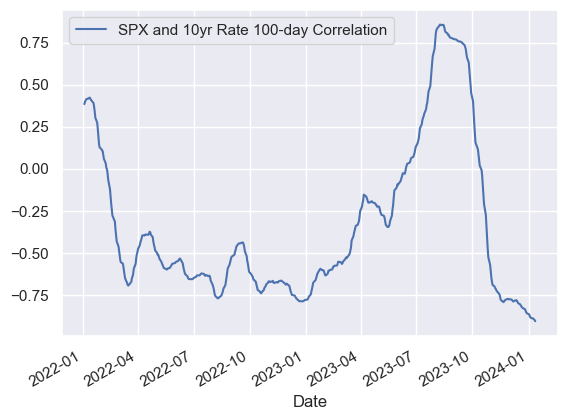

In [296]:
tickers = ['DGS10']
start = '1990-01-02'
end = dt.datetime.now()
rates = i.dataframe(tickers, data.set_index("DATE"), start, end)
r_e = pd.concat([rates, daily],axis=1).dropna()
corr = r_e.rolling(window=100).corr()['DGS10'].dropna()
corr_df = pd.DataFrame(corr).reset_index()
corr_df1 = corr_df[corr_df['ticker']=='SPY'].set_index('level_0')[['DGS10']]
corr_df1.columns = ['SPX and 10yr Rate 100-day Correlation']
corr_df1.index.names = ['Date']
corr_df1['2022':].plot()

In [297]:
final = main.load_sql().set_index("Date")
tickers =["SPY","LQD"]
start = '2000-01-01'
end = '2024-01-12'
dfcap = main.dataframe(tickers, final, start, end)
dfcap = dfcap.dropna()
dfcap.index = pd.to_datetime(dfcap.index)
daily = dfcap.copy()
daily

ticker             LQD         SPY
Date                              
2002-07-30   40.399170   60.274746
2002-07-31   40.646244   60.420574
2002-08-01   41.044788   58.843121
2002-08-02   41.128506   57.524120
2002-08-05   41.028847   55.522472
...                ...         ...
2024-01-08  107.866875  473.129974
2024-01-09  108.054070  472.412201
2024-01-10  107.916130  475.083893
2024-01-11  108.566353  474.874542
2024-01-12  108.802795  475.203522

[5402 rows x 2 columns]

<Axes: xlabel='Date'>

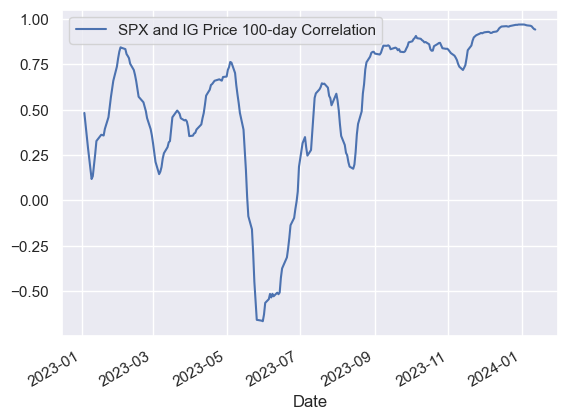

In [298]:
corr = daily.rolling(window=40).corr().dropna()[['LQD']]
corr_df = pd.DataFrame(corr).reset_index()
corr_df1 = corr_df[corr_df['ticker']=='SPY'].set_index('Date')[['LQD']]
corr_df1.columns = ['SPX and IG Price 100-day Correlation']
corr_df1.index.names = ['Date']
corr_df1['2023':].plot()

In [299]:
final = main.load_sql().set_index("Date")
tickers =["LQD","AGG","SPY"]
start = '2000-01-01'
end = '2024-01-12'
dfcap = main.dataframe(tickers, final, start, end)
dfcap = dfcap.dropna()
dfcap.index = pd.to_datetime(dfcap.index)
daily = dfcap.copy()
daily

ticker            AGG         LQD         SPY
Date                                         
2003-09-29  53.728931   47.736465   68.304550
2003-09-30  54.007652   48.053169   67.641350
2003-10-01  53.981396   48.191441   69.082809
2003-10-02  53.897259   48.006218   69.333214
2003-10-03  53.508091   47.338566   69.969368
...               ...         ...         ...
2024-01-08  97.684021  107.866875  473.129974
2024-01-09  97.664207  108.054070  472.412201
2024-01-10  97.475906  107.916130  475.083893
2024-01-11  98.030869  108.566353  474.874542
2024-01-12  98.209251  108.802795  475.203522

[5108 rows x 3 columns]

Fixed Income Outperforming during a Fed Pause

In [300]:
hc = daily[['AGG','LQD','SPY']]['2007-07-20':'2007-10-01'].pct_change().dropna()
hc_norm = (1 + hc).cumprod() - 1
fig = px.line(hc_norm.dropna().reset_index(), x="Date", y=['AGG','LQD','SPY'],
              hover_data={"Date": "|%B %d, %Y"},
              title='SPY v Fixed Income: Pause August 2007')

fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Cumulative Gains (Based on Price)"
)

Consumer Staples over Consumer Discretionary

In [301]:
final = main.load_sql().set_index("Date")
tickers =["XLY","XLP","SPY","XLV"]
start = '2000-01-01'
end = '2024-01-12'
dfcap = main.dataframe(tickers, final, start, end)
dfcap = dfcap.dropna()
dfcap.index = pd.to_datetime(dfcap.index)
daily = dfcap.copy()
daily

ticker             SPY        XLP         XLV         XLY
Date                                                     
2000-01-03   93.591141  12.798798   21.141119   22.678192
2000-01-04   89.931160  12.438389   20.661381   21.995977
2000-01-05   90.092056  12.658154   20.476028   21.725437
2000-01-06   88.644089  12.895493   20.541445   21.972450
2000-01-07   93.792244  13.712998   20.792215   23.007566
...                ...        ...         ...         ...
2024-01-08  473.129974  72.009850  139.845032  175.178406
2024-01-09  472.412201  72.198463  139.825104  174.529831
2024-01-10  475.083893  72.049561  140.462799  175.926773
2024-01-11  474.874542  72.039635  140.363144  175.697281
2024-01-12  475.203522  72.267952  140.014420  173.581894

[6046 rows x 4 columns]

In [304]:
hc = daily[['XLY','XLP','SPY']]['2019-10':'2020-01-01'].pct_change().dropna()
hc_norm = (1 + hc).cumprod() - 1
fig = px.line(hc_norm.dropna().reset_index(), x="Date", y=['XLY','XLP','SPY'],
              hover_data={"Date": "|%B %d, %Y"},
              title='Consumer Staples Outperforming in Contracting Growth - Real GDP YoY')

fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Cumulative Gains (Based on Price)")

In [303]:
hc = daily[['XLV','SPY']]['2019-10':'2020-01-01'].pct_change().dropna()
hc_norm = (1 + hc).cumprod() - 1
fig = px.line(hc_norm.dropna().reset_index(), x="Date", y=['XLV','SPY'],
              hover_data={"Date": "|%B %d, %Y"},
              title='Healthcare: Declining Growth')

fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Healthcare Outperforming in Contracting Growth - Real GDP YoY")